In [1]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
data_path = 'C:/Users/Admin/BE PROJECT/Data/covid_fulldata_preprocessed.csv'

data_csv = pd.read_csv(data_path)

In [4]:
data_csv

,Unnamed: 0,text,label
0,0,cdc currently report ninety-nine thousand and ...,1
1,1,"state report one thousand, one hundred and twe...",1
2,2,politically correct woman use pandemic excuse ...,0
3,3,"indiafightscorona one thousand, five hundred a...",1
4,4,populous state generate large case count look ...,1
...,...,...,...
20896,20896,chinese market cause new coronavirus video,0
20897,20897,peak new coronavirus happen week jan eighteen ...,0
20898,20898,store supermarket veracruz mexico close new co...,0
20899,20899,chain message circulate tuesday jan fourteen w...,0


In [5]:
data_csv.drop(labels = 'Unnamed: 0',axis=1,inplace=True)

In [6]:
data_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20901 entries, 0 to 20900
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20901 non-null  object
 1   label   20901 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 326.7+ KB


In [7]:
X = data_csv[['text']]

In [8]:
y = data_csv[['label']]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [10]:
train = pd.concat([X_train, y_train], axis=1)

In [11]:
test = pd.concat([X_test, y_test], axis=1)

C:\Users\Admin\anaconda3\envs\gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, '0'), Text(1, 0, '1')]

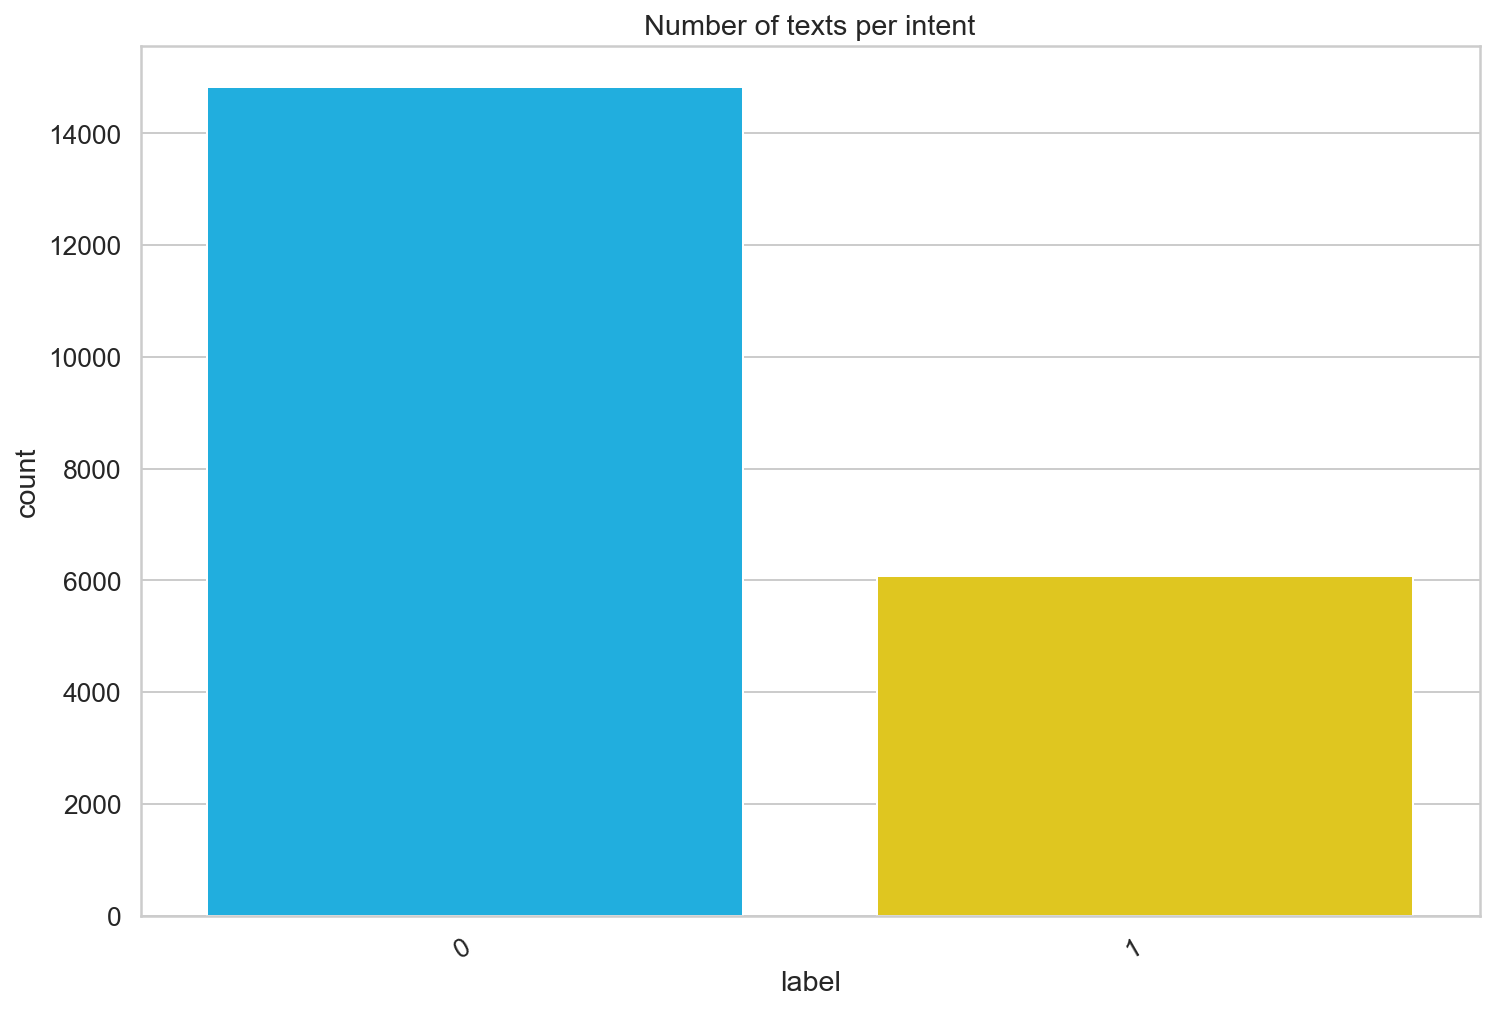

In [12]:
chart = sns.countplot(data_csv.label, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of texts per intent")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right')

In [13]:
bert_model_name = "uncased_L-2_H-128_A-2"

In [14]:
class FakeNews:
    DATA_COLUMN = "text"
    LABEL_COLUMN = "label"

    def __init__(self, train, test, tokenizer: FullTokenizer, classes=[0, 1], max_seq_len=192):
        self.tokenizer = tokenizer
        self.max_seq_len = 0
        self.classes = classes
    
        ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

        print("max seq_len", self.max_seq_len)
        self.max_seq_len = min(self.max_seq_len, max_seq_len)
        self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

    def _prepare(self, df):
        x, y = [], []
    
        for _, row in tqdm(df.iterrows()):
            text, label = row[FakeNews.DATA_COLUMN], row[FakeNews.LABEL_COLUMN]
            tokens = self.tokenizer.tokenize(text)
            tokens = ["[CLS]"] + tokens + ["[SEP]"]
            token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
            self.max_seq_len = max(self.max_seq_len, len(token_ids))
            x.append(token_ids)
            y.append(self.classes.index(label))

        return np.array(x), np.array(y)

    def _pad(self, ids):
        x = []
        for input_ids in ids:
            input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
            input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
            x.append(np.array(input_ids))
        return np.array(x)

In [15]:
vocab_file = 'C:/Users/Admin/BE PROJECT/BERT models/uncased_L-2_H-128_A-2/vocab.txt'

tokenizer = FullTokenizer(vocab_file)

In [16]:
tokenizer.tokenize("I can't wait to visit Bulgaria again!")

['i', 'can', "'", 't', 'wait', 'to', 'visit', 'bulgaria', 'again', '!']

In [17]:
tokens = tokenizer.tokenize("I can't wait to visit Bulgaria again!")
tokenizer.convert_tokens_to_ids(tokens)

[1045, 2064, 1005, 1056, 3524, 2000, 3942, 8063, 2153, 999]

In [34]:
def create_model(max_seq_len, bert_ckpt_file):

    with tf.io.gfile.GFile(bert_config_file, "r") as reader:
        bc = StockBertConfig.from_json_string(reader.read())
        bert_params = map_stock_config_to_params(bc)
        bert_params.adapter_size = None
        bert = BertModelLayer.from_params(bert_params, name="bert")
        
    input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
    bert_output = bert(input_ids)

    print("bert shape", bert_output.shape)

    cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
    cls_out = keras.layers.Dropout(0.1)(cls_out)
    logits = keras.layers.Dense(units=768, activation="relu")(cls_out)
    logits = keras.layers.Dropout(0.1)(logits)
    logits = keras.layers.Dense(units=512, activation="relu")(logits)
    logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

    model = keras.Model(inputs=input_ids, outputs=logits)
    model.build(input_shape=(None, max_seq_len))

    load_stock_weights(bert, bert_ckpt_file)
        
    return model

In [35]:
classes = train['label'].unique().tolist()

In [36]:
classes = sorted(classes)

In [37]:
data = FakeNews(train, test, tokenizer, classes, max_seq_len=512)

18810it [00:06, 2933.12it/s]
C:\Users\Admin\anaconda3\envs\gpu\lib\site-packages\ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
2091it [00:00, 2887.87it/s]


max seq_len 1241


In [38]:
bert_ckpt_file = 'C:/Users/Admin/BE PROJECT/BERT models/uncased_L-2_H-128_A-2/bert_model.ckpt'
bert_config_file = 'C:/Users/Admin/BE PROJECT/BERT models/uncased_L-2_H-128_A-2/bert_config.json'
model = create_model(data.max_seq_len, bert_ckpt_file)

bert shape (None, 512, 128)
Done loading 36 BERT weights from: C:/Users/Admin/BE PROJECT/BERT models/uncased_L-2_H-128_A-2/bert_model.ckpt into <bert.model.BertModelLayer object at 0x0000025F9608C0C8> (prefix:bert_2). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [39]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 512)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 512, 128)          4369152   
_________________________________________________________________
lambda_2 (Lambda)            (None, 128)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 768)               99072     
_________________________________________________________________
dropout_5 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               3937

In [40]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [41]:
checkpoint_filepath = 'C:/Users/Admin/BE PROJECT'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)



history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=16,
  shuffle=True,
  epochs=5,
  callbacks=[model_checkpoint_callback]
)

Train on 16929 samples, validate on 1881 samples
Epoch 1/5
16929/16929 [==============================] - 82s 5ms/sample - loss: 0.5071 - acc: 0.8016 - val_loss: 0.4439 - val_acc: 0.8660
Epoch 2/5
16929/16929 [==============================] - 78s 5ms/sample - loss: 0.4357 - acc: 0.8761 - val_loss: 0.4105 - val_acc: 0.8990
Epoch 3/5
16929/16929 [==============================] - 78s 5ms/sample - loss: 0.4092 - acc: 0.9009 - val_loss: 0.3955 - val_acc: 0.9149
Epoch 4/5
16929/16929 [==============================] - 77s 5ms/sample - loss: 0.3944 - acc: 0.9169 - val_loss: 0.3912 - val_acc: 0.9192
Epoch 5/5
16929/16929 [==============================] - 77s 5ms/sample - loss: 0.3885 - acc: 0.9221 - val_loss: 0.3866 - val_acc: 0.9250


In [145]:
cd

C:\Users\Admin


In [42]:
model.save('bert-tiny-2-coviddata.h5')

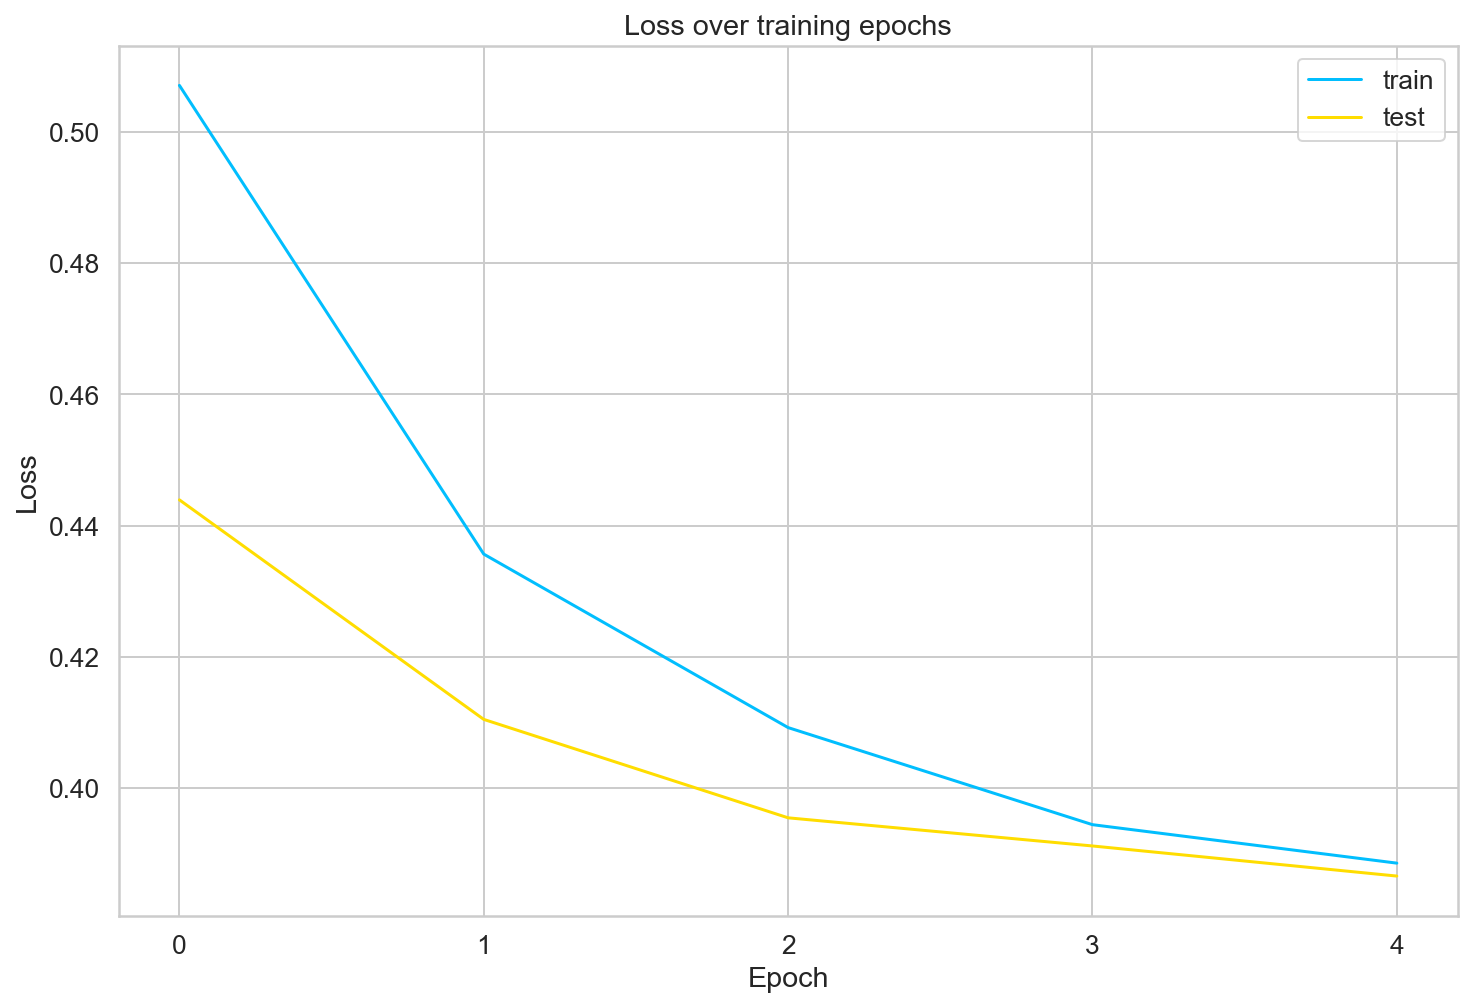

In [43]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

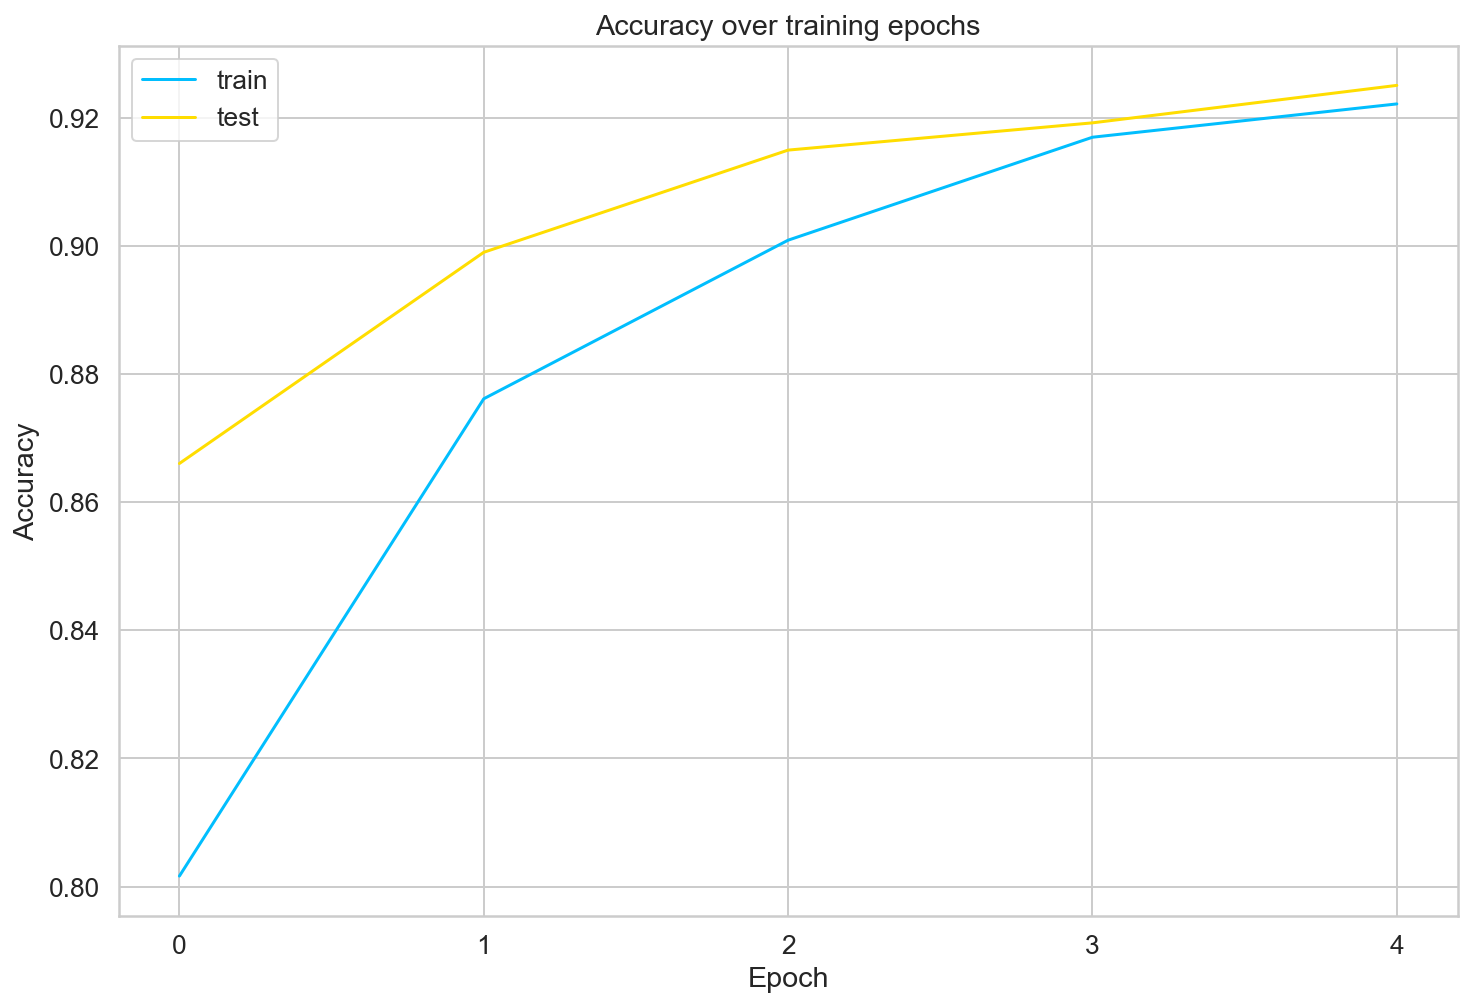

In [44]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')
plt.show();

In [45]:
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

2091/2091 [==============================] - 3s 1ms/sample - loss: 0.3821 - acc: 0.9316
train acc 0.9354067
test acc 0.93161166


In [46]:
y_pred = model.predict(data.test_x).argmax(axis=-1)

In [47]:
cm = confusion_matrix(data.test_y, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

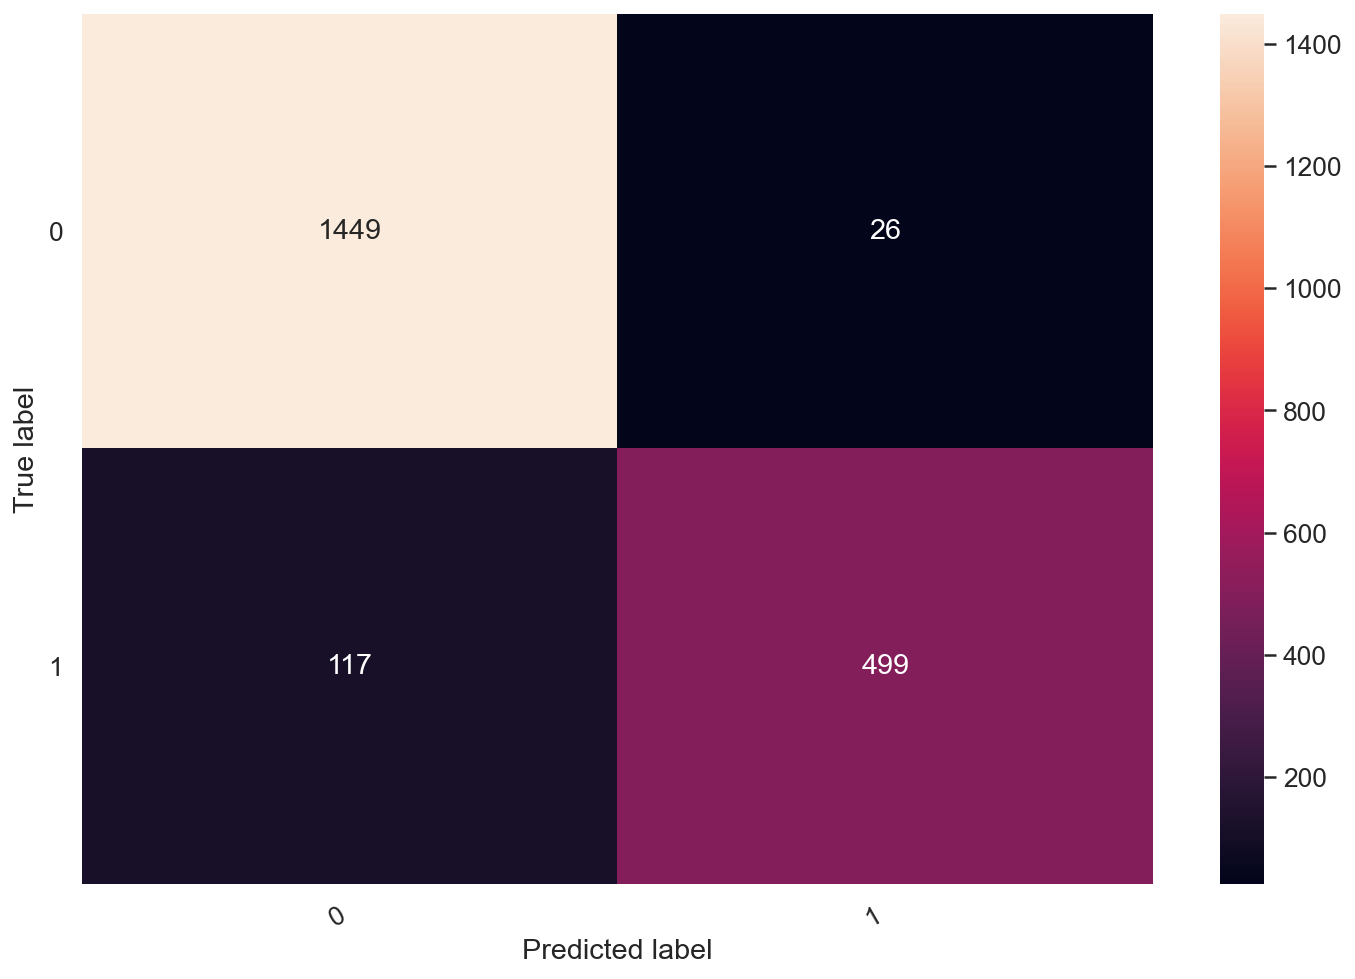

In [48]:
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [ ]:
data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABUsAAAPTCAYAAACJxFgbAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8QVMy6AAAACXBIWXMAABYlAAAWJQFJUiTwAACOQUlEQVR4nOzdeZyWdb038M/ADMywKYiyWSoJRyMtTVRQUyz1uHWUsDJzOa7HBVITLfNYaaapZKZmiGQZalmA9phFegxxATfQTFFw66AJhuwwwMDczx+cmSBmWAfugXm/n9f9em6v6/e9ru/N6VX68beUFAqFQgAAAAAAmrhmxW4AAAAAAKAxEJYCAAAAAERYCgAAAACQRFgKAAAAAJBEWAoAAAAAkERYCgAAAACQRFgKAAAAAJBEWAoAAAAAkERYCgAAAACQRFgKAAAAAJBEWAoAAAAAkERYCgAAAACQRFgKAAAAAJAkKS12A1uLqplvFbsFAGArUtH1oGK3AABsZZYtfa/YLTQaW1qOU9axe7FbaDLMLAUAAAAAiLAUAAAAACCJsBQAAAAAIIk9SwEAAABoaqqXF7sDGikzSwEAAAAAIiwFAAAAAEhiGT4AAAAATU2hutgd0EiZWQoAAAAAEGEpAAAAAEASy/ABAAAAaGqqLcOnbmaWAgAAAABEWAoAAAAAkERYCgAAAACQxJ6lAAAAADQxhYI9S6mbmaUAAAAAABGWAgAAAAAksQwfAAAAgKam2jJ86mZmKQAAAABAhKUAAAAAAEmEpQAAAAAASexZCgAAAEBTU7BnaX1mz56do48+OqWlpRk3btw61y1fvjxf+cpX8uKLL+aCCy7IwIED6x07efLk3HHHHXnuuecyZ86cdOjQIX369MkZZ5yRnj171ltXKBQycuTI/Pa3v83rr7+eJNlxxx1z5JFH5vTTT095efm6/9B6CEsBAAAAgFRVVeUb3/hGPvzww3Tq1Gm9an/yk5/kxRdfXOu4xx9/POeff36qqqpSUlKSNm3aZMaMGXnggQfyhz/8IUOGDMlhhx22Wl2hUMhll12WBx98MEnSokWLlJaWZsqUKZkyZUp+//vf55e//GU6dOiwXn3/K8vwAQAAAKCJq6yszIUXXpixY8eud+2kSZNy++23r3XctGnTcuGFF6aqqipHHnlknnzyyTz//PMZO3Zs+vXrlyVLlmTw4MGZNm3aarXDhg3Lgw8+mLKyslxzzTWZOHFiJk2alGHDhmX77bfPG2+8kcGDB6937/9KWAoAAABA01K9fMv6bGJTpkzJCSeckEcffXS9axcsWJDBgwenUCikRYsWaxw7dOjQLFq0KLvttluGDBmSjh07Jkm6dOmSW265Jb169UplZWVuvfXWVeoWLlyY4cOHJ0kuuuiiDBgwIGVlZUmSz3zmM7n99ttTUlKSJ598MhMmTFjv37AyYSkAAAAANEGLFy/OlVdemeOOOy5Tp05Nx44d069fv/V6xve+971MmzYtp512Wrbffvt6xy1atKh2Cf2pp56a5s2br3K/rKwsZ555ZpJkzJgxqaysrL338MMPZ86cOSkvL89XvvKV1Z69xx575MADD0yS2ndsKGEpAAAAADRBM2fOzK9//essX748RxxxRH73u9+lV69e61z/xz/+MaNHj07Pnj1z0UUXrXHspEmTsnTp0iRJ37596xzTp0+fJCu2BHj22Wdrr9fMFt1rr71SUVFRZ23NMx9//PF17r8uDngCAAAAoGkpVBe7g0ahpKQkBxxwQM4777zss88+61U7ffr0XHnllSkrK8sNN9yw1iX4U6dOTZK0atUqnTt3rnNM+/bts+2222bOnDmZOnVqDj744CTJG2+8kSTp3r17vc/feeedkyQffvhhZs2atcEHPQlLAQAAAKAJ6tatW372s5+td13NyfRz587NJZdckt12222tNTNmzEiSeoPSGjvssEPmzJlTO35da3fYYYdVxgtLAQAAAGArNGrUqIwePXqdxx9//PHp37//Jutn+PDhmTBhQnr37p0zzjhjnWoWLlyYJPUuo69RXl6eZMXBUTVqvrdq1areupWfu3Lt+hKWAgAAAEAj9t57762yh+fa7Lvvvpusl8mTJ+dHP/pR2rRpk+uuuy7Nmq3bkUhVVVVJstbl+jX3ly9fXntt2bJlSVYcArW2upXHbwhhKQAAAABNS/WWtWdpt27d1isA7dat2ybpY/HixbnkkktSVVWVq6++OjvuuOM619bMGK055Kk+NfdXDkbLy8tTWVlZG7iuqe5fa9eXsBQAAAAAGrH+/ftv0mX16+oHP/hB3njjjRx++OE5/vjj16u2devWSZIlS5ascdzixYuTJG3atFmltrKysvZeXSorK2u/r1y7voSlAAAAAMBa3XvvvUmSCRMm5IADDljt/qxZs5IkP/vZz/KrX/0qSfLUU08lSbp06ZIkqxzcVJea+506daq91rlz58ycOXONtSvfW7l2fQlLAQAAAGhSCoUtaxl+YzNv3rw13l+0aFEWLVq0yrUePXokSebPn5+ZM2emY8eOq9XNmjUrc+fOTZLsuuuutdd79uyZv/71r3n77bfrfec777yTJNluu+3Svn37dfoddRGWAgAAAABr9frrr6/x/qGHHpr33nsvF1xwQQYOHLjKvT322COtWrXKokWLMn78+Bx77LGr1Y8fPz7Jij1H995779rr++23X0aNGpWJEydm6dKldR4S9fTTTydJ9t9///X+XStbt+OqAAAAAAA2UEVFRQ499NAkyfDhw1c76KmqqirDhw9Pkhx77LGr7Dv62c9+NuXl5Vm4cGHuvvvu1Z798ssv1y73P/HEEzeqT2EpAAAAALDJDRo0KC1btszkyZMzcODATJ8+PUkyffr0DBw4MK+88koqKipyzjnnrFLXtm3b2ms33XRT7r777tqw9cknn8y5556bQqGQvn37pnfv3hvVo2X4AAAAADQt1fYsLYaddtop1113XQYPHpyxY8fmkEMOSdu2bTN//vwUCoWUlpbmpptuys4777xa7VlnnZVXX301jzzySK655ppcf/31KSsrq90bddddd82PfvSjje5RWAoAAAAAbBZHHXVUunfvnmHDhuWZZ57J7Nmz06FDh/Tu3Ttnn312evXqVWddWVlZbrnllowcOTIjR47MlClTsmTJknTv3j2HH354zjrrrFWW7m+okkKhUNjop5CqmW8VuwUAYCtS0fWgYrcAAGxlli19r9gtNBpLpj5d7BbWS8sefYvdQpNhZikAAAAATUvBMnzq5oAnAAAAAIAISwEAAAAAkliGDwAAAEBTU7282B3QSJlZCgAAAAAQYSkAAAAAQBJhKQAAAABAEnuWAgAAANDUFKqL3QGNlJmlAAAAAAARlgIAAAAAJLEMHwAAAICmptoyfOpmZikAAAAAQISlAAAAAABJhKUAAAAAAEnsWQoAAABAU1OwZyl1M7MUAAAAACDCUgAAAACAJJbhAwAAANDUVFuGT93MLAUAAAAAiLAUAAAAACCJZfgAAAAANDGFwvJit0AjZWYpAAAAAECEpQAAAAAASYSlAAAAAABJ7FkKAAAAQFNTqC52BzRSZpYCAAAAAERYCgAAAACQxDJ8AAAAAJqaasvwqZuZpQAAAAAAEZYCAAAAACQRlgIAAAAAJLFnKQAAAABNTcGepdTNzFIAAAAAgAhLAQAAAACSWIYPAAAAQFNTvbzYHdBImVkKAAAAABBhKQAAAABAEsvwAQAAAGhqCtXF7oBGysxSAAAAAIAISwEAAAAAkghLAQAAAACS2LMUAAAAgKam2p6l1M3MUgAAAACACEsBAAAAAJJYhg8AAABAU1OwDJ+6mVkKAAAAABBhKQAAAABAEmEpAAAAAEASe5YCAAAA0NRU27OUuplZCgAAAAAQYSkAAAAAQBLL8AEAAABoaizDpx5mlgIAAAAARFgKAAAAAJDEMnwAAAAAmphCYXmxW6CRMrMUAAAAACDCUgAAAACAJMJSAAAAAIAk9iwFAAAAoKmpri52BzRSZpYCAAAAAERYCgAAAACQxDJ8AAAAAJqagmX41M3MUgAAAACACEsBAAAAAJIISwEAAAAAktizFAAAAICmptqepdTNzFIAAAAAgAhLAQAAAACSWIYPAAAAQFNTsAyfuplZCgAAAAAQYSkAAAAAQBLL8AEAAABoaqotw6duZpYCAAAAAERYCgAAAACQRFgKAAAAAJDEnqUAAAAANDUFe5ZSNzNLAQAAAAAiLAUAAAAASGIZPgAAAABNTbVl+NTNzFIAAAAAgAhLAQAAAACSCEsBAAAAAJLYsxQAAACApsaepdTDzFIAAAAAgAhLAQAAAACSWIYPAAAAQFNTsAyfuplZCgAAAAAQYSkAAAAAQBLL8AEAAABoaqotw6duZpYCAAAAAERYCgAAAACQRFgKAAAAAJDEnqUAAAAANDUFe5ZSNzNLAQAAAAAiLAUAAAAASGIZPgAAAABNTbVl+NTNzFIAAAAAgAhLAQAAAACSCEsBAAAAAJLYsxQAAACApqZgz1LqZmYpAAAAAECEpQAAAAAASSzDBwAAAKCpqbYMvz6zZ8/O0UcfndLS0owbN67ecW+88UbuvvvuTJgwIdOnT0+zZs3SrVu3fOYzn8lpp52WTp061Vs7efLk3HHHHXnuuecyZ86cdOjQIX369MkZZ5yRnj171ltXKBQycuTI/Pa3v83rr7+eJNlxxx1z5JFH5vTTT095efmG//D/U1IoFAob/RRSNfOtYrcAAGxFKroeVOwWAICtzLKl7xW7hUaj8rffK3YL66ViwBWb5T1VVVW54IILMnbs2HTq1KnesHTkyJH59re/naqqqiRJmzZtsnjx4ixbtixJss022+S2225L7969V6t9/PHHc/7556eqqiolJSVp06ZN5s+fnyRp2bJlhgwZksMOO2y1ukKhkMsuuywPPvhgkqRFixYpLS3NokWLkiS77rprfvnLX6ZDhw4b9WdgGT4AAAAANHGVlZW58MILM3bs2DWOe+mll3LFFVekqqoqBx98cB5++OG88MILefHFF/Pzn/88u+yyS+bOnZvzzjsvH3zwwSq106ZNy4UXXpiqqqoceeSRefLJJ/P8889n7Nix6devX5YsWZLBgwdn2rRpq7132LBhefDBB1NWVpZrrrkmEydOzKRJkzJs2LBsv/32eeONNzJ48OCN/nMQlgIAAADQtFRXb1mfTWzKlCk54YQT8uijj6517E9+8pNUV1dnl112ya233pqPfexjSZKysrL06dMnd911V9q1a5d58+blF7/4xSq1Q4cOzaJFi7LbbrtlyJAh6dixY5KkS5cuueWWW9KrV69UVlbm1ltvXaVu4cKFGT58eJLkoosuyoABA1JWVpYk+cxnPpPbb789JSUlefLJJzNhwoSN+rMQlgIAAABAE7R48eJceeWVOe644zJ16tR07Ngx/fr1q3d8VVVVnnrqqSTJySefnBYtWqw2pkuXLjnkkEOSJM8++2zt9UWLFtUuoT/11FPTvHnzVerKyspy5plnJknGjBmTysrK2nsPP/xw5syZk/Ly8nzlK19Z7Z177LFHDjzwwCSpfceGEpYCAAAAQBM0c+bM/PrXv87y5ctzxBFH5He/+1169epV7/hFixbl+OOPz8EHH5w99tij3nHbb799ktTuRZokkyZNytKlS5Mkffv2rbOuT58+SVZsCbBy0FozW3SvvfZKRUVFnbU1z3z88cfr7WtdlG5UNQAAAACwRSopKckBBxyQ8847L/vss89ax2+zzTa5+uqr1zpu4sSJSVbMMq0xderUJEmrVq3SuXPnOuvat2+fbbfdNnPmzMnUqVNz8MEHJ0neeOONJEn37t3rfefOO++cJPnwww8za9asDT7oSVgKAAAAQNNSKBS7g0ahW7du+dnPftagz3zyySczadKkJKldjp8kM2bMSJJ6g9IaO+ywQ+bMmVM7fl1rd9hhh1XGC0sBAAAAYCs0atSojB49ep3HH3/88enfv/8m7Khu06dPzze+8Y0kK5bif/GLX6y9t3DhwiSpdxl9jfLy8iTJggULaq/VfG/VqlW9dSs/d+Xa9SUsBQAAAIBG7L333ltlD8+12XfffTdhN3X74IMPcuqpp+Yf//hHmjdvnhtuuGGVALOqqipJ6jwUamU195cvX157bdmyZUlWHAK1trqVx28IYSkAAAAATUt1dbE7WC/dunVbrwC0W7dum7Cb1b3zzjs544wz8u6776akpCTf+c53ag9rqlEzY7TmkKf61NxfORgtLy9PZWVlbeC6prp/rV1fwlIAAAAAaMT69+9flGX16+LZZ5/NwIEDM2fOnDRr1ixXXXVVTjjhhNXGtW7dOkmyZMmSNT5v8eLFSZI2bdqsUltZWVl7ry6VlZW131euXV/NNrgSAAAAAGiyHnzwwZx++umZM2dOWrZsmZtvvrnOoDRJunTpkiSrHNxUl5r7nTp1qr1Wc7DTmmpXvrdy7foSlgIAAAAA62XYsGG59NJLU1VVlW233TZ33XVXDj/88HrH9+jRI0kyf/78zJw5s84xs2bNyty5c5Mku+66a+31nj17Jknefvvtep//zjvvJEm22267tG/ffr1+y8qEpQAAAAA0LdXVW9ankfnFL36RG2+8MUmy44475le/+lU+/elPr7Fmjz32qD3Nfvz48XWOqbleVlaWvffeu/b6fvvtlySZOHFivXuePv3000mS/ffffz1+yeqEpQAAAADAOhk/fnyuu+66JMnHPvax3Hfffdlll13WWldRUZFDDz00STJ8+PDVQs+qqqoMHz48SXLssceusu/oZz/72ZSXl2fhwoW5++67V3v2yy+/nKeeeipJcuKJJ27YD/s/wlIAAAAAYK2WLVuWK664ItXV1Wnbtm1++tOfZocddljn+kGDBqVly5aZPHlyBg4cmOnTpydJpk+fnoEDB+aVV15JRUVFzjnnnFXq2rZtW3vtpptuyt13310btj755JM599xzUygU0rdv3/Tu3XujfmPpRlUDAAAAwJam0PiWtm8JxowZk3fffTdJsnTp0rXO4uzcuXNGjhxZ+9c77bRTrrvuugwePDhjx47NIYcckrZt22b+/PkpFAopLS3NTTfdlJ133nm1Z5111ll59dVX88gjj+Saa67J9ddfn7KysixatCjJij1Of/SjH230bxSWAgAAAABrNXHixNrvS5YsyZIlS9Y4vmXLlqtdO+qoo9K9e/cMGzYszzzzTGbPnp0OHTqkd+/eOfvss9OrV686n1VWVpZbbrklI0eOzMiRIzNlypQsWbIk3bt3z+GHH56zzjprlaX7G6qkUCgUNvoppGrmW8VuAQDYilR0PajYLQAAW5llS98rdguNRuWIbxW7hfVS8dVrit1Ck2FmKQAAAABNSyM8YZ7GwQFPAAAAAAARlgIAAAAAJBGWAgAAAAAksWcpAAAAAE2N886ph5mlAAAAAAARlgIAAAAAJLEMHwAAAICmprq62B3QSJlZCgAAAAAQYSkAAAAAQBJhKQAAAABAEnuWAgAAANDU2LOUephZCgAAAAAQYSkAAAAAQBLL8AEAAABoagqW4VM3M0sBAAAAACIsBQAAAABIYhk+AAAAAE1MobpQ7BZopMwsBQAAAACIsBQAAAAAIImwFAAAAAAgiT1LAQAAAGhqqquL3QGNlJmlAAAAAAARlgIAAAAAJLEMHwAAAICmpmAZPnUzsxQAAAAAIMJSAAAAAIAkwlIAAAAAgCT2LAUAAACgqakuFLsDGikzSwEAAAAAIiwFAAAAAEhiGT4AAAAATU11dbE7oJEysxQAAAAAIMJSAAAAAIAkluEDAAAA0NRYhk89zCwFAAAAAIiwFAAAAAAgibAUAAAAACCJPUsBAAAAaGoKhWJ3QCNlZikAAAAAQISlAAAAAABJLMMHAAAAoKmpri52BzRSZpYC/IvXpryZTx18bI498awNqv/va2/KJw44Mod/4dRNXv/XyVPyzatvzGH9T81ehxybPkcMyGkXXJrfPPhwqpYt26D3AwDFt9++e+fOYT/M5FeezNzZUzN/7huZ8trTuetnN2e/ffdeY21JSUlOOukLeeh3v8y7/zspixa8nfff+0v+34N35/OfP2Iz/QIA2DKZWQqwklmz5+TS7/4gyzYwaBzz2BMZ/dCfNvj961N/yx13Z+gv7lvlWlXVsjw/6eU8P+nl/ObBP+TWH3wnO2y/3Qb3AwBsfkNu+E6+9rXV/6Vt9+47pXv3nXLyVwfkhhtvyzcv//5qY7bbrn0eGPXz9OmzzyrXt99+uxx55Gdz5JGfzd2//E3OPOviVJtVBQCrMbMU4P/M+MfMnD7wG3nrnWkbVP/+9A/y3et/vMHvX5/64SPurw1Kt9+uQ75z2dfyPw/8MmN/d0+uvXJwOu3QMa++/kZOOufizF+wcIN7AgA2r8u/+bXaoHT8+Odz7OdPTpdue2bXnvvnSyeek9defyNJMviS8zP4kvNWqW3evHke/v29tUHpT27/efb69OeyQ+dP5OBDjsvYsU8nSU45+YRc/s1Bm/FXATRC1YUt68Nms1WGpY888khOPfXU7LPPPtlzzz1zxBFH5IYbbsicOXOK3RrQSI196pl84dTz88bbf9ug+uXLl+cbV92QefMXbPL6Gf+YmduGj0iSdNp+u9x3548y4PP/nk7bd0zH7Trk2CMOzb133JTtt+uQ92d8kJtu/9kG9QQAbF4dOrTPN78xMEkybtz49PvsF/KHPz6Wf/zjw7zzzrSMHPlQPr3P4Xnu+ReTJFd866K0b79tbf0lXz83n957zyTJoK99K4O+9q28/PLkzJo1O089/VyOOPLLmTjp5STJRReek4qK8s36+wBgS7DVhaU33XRTLrjggkyYMCGVlZUpLS3NO++8kzvvvDOf//zn87e/bVgQAmydpr71Ti649Du54NLvZM7ceenQftt06bTDej9n6C9+lRde+mt2/ki37L1nr01a/4dHH8/SpVVJkksHnZPOO2y/2phO23fMeWeclCQZ+f/+mJmzZq93TwDA5nXsMYeloqIiSfLfV9a9LdCSJUty9dU/TJK0bt0qhx56YJKkWbNmueD805MkjzzyeH5y+89Xq12+fHlu/vGwJCtmoX5yA/6eBQC2dltVWPrwww/npz/9aUpKSvL1r389L7zwQiZOnJj7778/O++8c2bMmJHzzz8/y5cvL3arQCPxje/ekLFPPZMk+UzfffObu25Jt66d1usZk15+NUN/fm9KS0tz3bcvXe9ZGutb/9fJU5IkLVu0yKEH7V/vuM/03TdJsnx5dZ5+duJ69QQAbH477tg1CxcuSpI88+ykesdNfePtf9Z065IkObTfAenSZcXfw1x7Xf3b+tx33+i0arNLtu3QMxOeeaEh2gaArcpWE5ZWV1fnxz9e8TcFX/nKV3L22WenvHxF4PDJT34yP//5z9OqVatMnTo1DzzwQBE7BRqb3Xt+LLfd8N385IbvptP2Hderdv6ChbnsOz/I8uXVOf+Mr+YTu/fc5PVz581PkmzfsUPKysrqHddhpWV5r099a736AgA2v2u+/6Ns075HOnTcbY2HTfbs0b32++zZc5Mk++336STJokWVeerp51YZX1r6z3N9q6urs3Tp0oZsG2DLVKjesj5sNltNWDphwoS8/faKf8P6n//5n6vd79KlSz7/+c8nibAUqHXDVd/Ib+66NQf/3yzM9fXd63+cv0//IPvstUfO+OoJm6W+datWSVb8w9Ca1ISqSTL9g5nr3RsAUBzzVvrf8Lqcd+5ptd+feHJCkmSPPXZPkrz19t+yfPny7L57j9wx9MZM+9vELFrwdubPfSP/88hv0r//0ZusbwDYGmw1Yekzz6xYRvvRj340H/nIR+oc07dv3yTJCy+8kIULnQ4NJN13qvu/L9bF6N//KX/8n3Fp17ZNrr3ikjRrtn7/lbqh9T0+tnOSZNacuXltypv1jnvm/w5/SJKFixatV28AQON02qlfyhFH9EuS/P73j+btt/83SdKta+ckycx/zMppp34pzz87Jqf/54np0qVTmjVrloqKihx8cN/c/6s78ouf/zjNmzcv2m8AgMZsqwlLp06dmiTp3r17vWN23nnnJCs2Nn/zzfoDBoC1+du09/L9m25Pkvz3JRekS+f1OxRqY+r//bOfqQ1Wv3/T7VmyZPWldPPmL8htw0fU/nVVVdV69QcAND7/fkS/3HbrtUmS2bPn5KKvX1l7r03b1kmS3XfvkZ/efn1mzpyVU/9zULbv1Cut23bPwYccl3HjxidJTvrKF/KDa6/Y/D8AoDGpLmxZHzabrSYsnTFjRpKkc+fO9Y7ZYYd/hhEffPDBJu8J2DpVLVuWwd/+QSorF+fYf/9sjvzcwZu1/mM7fzRf7n9MkmTiX17JSedclMeeGJ8PZ8/JzFmzM+axJ/KVsy7Me+9PT8ft2ifJGvc2BQAav/79j85vf3NnWrZsmaVLl+arJ5+ft976W+39VhUVSZJOnbbPzJmzcsBBn88994zM7NlzsmTJkjz19HM57Igv5bHHnkySXHDB6enRo/6JJgDQVJWufciWYcGCBUmSVv+3l19dKv7vbyBWHg+wvm7+6c/z6utTs2PXzvnWxedu9vokuXTg2Zm/YGH+3x//J69NfSuDvnHVKvcrylvmmm99Pb/93R8y88PZaVVRvkHvAQCK78KvnZ0fXHdFmjdvniVLluTEk87NmD+NXWXMosp/7mV+7XU/zrvv/n215yxfvjyXf+v7mTD+4ZSWluYL/Y/OdT+4ZVO3DwBblK0mLK05LXJNs6datGix2niA9fH0sxPzi1+NSvPmzXLtlYPTpnXrzVpfo7S0ea7970tyxKEH5dejf5+XX309iyors0PH7XLQ/r1z8peOy0d37Jqhv/hVkmT7jttt0HsAgOJp0aJFbv/JD3LqKV9MksydOy8nfPGsPPbnJ1cbO3/ePyeD/M9jT9T7zOdfeCnz5y9I27Zt0qvXvzV80wCwhdtqwtLy8hWzpta0L9/Spf/c18+SVGBD/P5Pf06hUMjy5YWc/F9fX+PYv0//IJ844MgkyX8c+blcc8XXN7r+Xx1ywH455ID96qxfVLk4f5v2XpKNO8gKANj8dtihY0aPvCv77bd3kuSdd6blP44/Na+88nqd4996+3/Tt2/vJEll5eI1PnvevPlp27ZNKqw8AZqwQnV1sVugkdpq9ixt/X+zsxYvrv9vDCpXWprSpk2bTd4TwKZSKBQyd978VK/hf+CffvaF2vuf/MTum6s1AGAj7bLLR/PkuN/VBqXjxz+fvgceU29QmiQvvvjX2u+7fmyXesc1b9482/3fnubvvvt+A3UMAFuPrWZmaefOnfPSSy/VHvRUl5XvderUaXO0BWxlvn3pwHzr4vPWOGbQN6/OhOcnpUunHfLgiJ8mWbFsviHqk+SZF17MORf/d5YtW5Y7b/5+9t9nrzqf85sH/5Ak2ekj3bKbAxwAYIvQpUunPPqn32SnnXZMkvzq1w/k9DMuWmWVXF3+30N/yo03fDtJ8uUvH1fvUvx+h/StXZX39PjnGrBzANg6bDUzS3v27Jkkefvtt+sd88477yRJmjVrlu7dBQfA+mvRokVatapY46d58xX/1VpSktprNXsmb2x9knz833qktPmK8PSe3/yuzj4f+P0jeeqZF5Ik//mVAZvszwMAaDjNmjXLvSN+UhuUDr3jl/nqyeevNShNkjfffCePPjouSXLKySfks4cetNqYVq0qcu21VyRJ/vGPD/PAA39swO4BtjDVhS3rw2az1YSl++23Ys++t956q97ZpU8//XSSZM8990yrVq02W28ADaltm9Y58QvHJkn+/OSEfOOqG/Lq629kztx5eW3Km7lmyE/y39felCTp03uvfOHYI4rZLgCwjv7ztC/noIP2T5JMmPBCLv/W99O6das1flY+i+G8C76RefPmp3nz5vndg7/Id759Sf7t3z6WDh3a54jDD8njYx/IXp/6RJLkgkGXr1MICwBNzVazDP/Tn/50OnfunOnTp+enP/1pvv3tb69y//3338/vfrdiBtaJJ55YjBYBGszAs07O23+blrFPPZOHxjyWh8Y8ttqYg/r0zo3f/UZKSkqK0CEAsL4uvPDs2u/77//pfPiPyWutuerqIbnq6h8mSd5662/53GEnZNTIu7Ljjl1yxbcuyhXfumiV8VVVVRl86VUZOfKhhm0eALYSW01Y2qxZs1x88cW59NJLc++996Zdu3Y5++yz07p16/zlL3/JpZdemsrKynzsYx/LMcccU+x2ATZKixYtcssPvp2H/vTnPPD7P2XylDezaFFl2rVrmz0+3jPHH314PnfwAcVuEwBYRx06tM/uu/XY6OdMnPRyPv6Jg3Luf52a4487Kj17dk9FRXmmvft+/vznp/KT2+9a40FRAE1Gof7DcmnaSgqFwla18cHVV1+dESNGJElKS0tTXl6eBQsWJEm23377/OpXv8qOO+7Y4O+tmvlWgz8TAGi6Krquvt8gAMDGWLb0vWK30Ggs/N5Xi93Ceml9xYhit9BkbDV7ltb47//+79x2223p27dvWrdunSVLlmTHHXfMySefnAceeGCTBKUAAAAAwJZvq1mGv7LPfe5z+dznPlfsNgAAAACALchWGZYCAAAAQL2qt6pdKWlAW90yfAAAAACADSEsBQAAAACIZfgAAAAANDXV1cXugEbKzFIAAAAAgAhLAQAAAACSCEsBAAAAAJLYsxQAAACApqa6UOwOaKTMLAUAAAAAiLAUAAAAACCJZfgAAAAANDWF6mJ3QCNlZikAAAAAQISlAAAAAABJLMMHAAAAoKmpLhS7AxopM0sBAAAAACIsBQAAAABIIiwFAAAAAEhiz1IAAAAAmphCdXWxW6CRMrMUAAAAACDCUgAAAACAJJbhAwAAANDUVBeK3QGNlJmlAAAAAAARlgIAAAAAJBGWAgAAAAAksWcpAAAAAE2NPUuph5mlAAAAAAARlgIAAAAAJLEMHwAAAICmplBd7A5opMwsBQAAAACIsBQAAAAAIIll+AAAAAA0NdWFYndAI2VmKQAAAABAhKUAAAAAAEmEpQAAAAAASexZCgAAAEATU7BnKfUwsxQAAAAAIMJSAAAAAIAkluEDAAAA0NRYhl+v2bNn5+ijj05paWnGjRtX77iFCxfmzjvvzJgxYzJt2rRUVFSkR48eOeGEE3Lcccet8R2TJ0/OHXfckeeeey5z5sxJhw4d0qdPn5xxxhnp2bNnvXWFQiEjR47Mb3/727z++utJkh133DFHHnlkTj/99JSXl2/Qb15ZSaFQ8J+OBlA1861itwAAbEUquh5U7BYAgK3MsqXvFbuFRmP+oGOK3cJ6afvjhzbLe6qqqnLBBRdk7Nix6dSpU71h6bx583LSSSdlypQpSZJWrVqlqqoqVVVVSZKjjz46N954Y5o1W31R++OPP57zzz8/VVVVKSkpSZs2bTJ//vwkScuWLTNkyJAcdthhq9UVCoVcdtllefDBB5MkLVq0SGlpaRYtWpQk2XXXXfPLX/4yHTp02Kg/A8vwAQAAAKCJq6yszIUXXpixY8eudezFF1+cKVOmpGvXrhkxYkQmTZqUiRMn5oorrkhpaWl+//vf584771ytbtq0abnwwgtTVVWVI488Mk8++WSef/75jB07Nv369cuSJUsyePDgTJs2bbXaYcOG5cEHH0xZWVmuueaaTJw4MZMmTcqwYcOy/fbb54033sjgwYM3+s9BWAoAAAAATdiUKVNywgkn5NFHH13r2IkTJ+aJJ55Iktx8883p3bt3khUzPU8++eRccsklSZKhQ4fWzhitMXTo0CxatCi77bZbhgwZko4dOyZJunTpkltuuSW9evVKZWVlbr311lXqFi5cmOHDhydJLrroogwYMCBlZWVJks985jO5/fbbU1JSkieffDITJkzYiD8JYSkAAAAATU119Zb12UQWL16cK6+8Mscdd1ymTp2ajh07pl+/fmusuffee5Mk++67b/bcc8/V7p900klp27ZtFixYsEr4umjRotol9KeeemqaN2++Sl1ZWVnOPPPMJMmYMWNSWVlZe+/hhx/OnDlzUl5enq985SurvXOPPfbIgQcemCS179hQwlIAAAAAaIJmzpyZX//611m+fHmOOOKI/O53v0uvXr3WWPPMM88kSfr06VPn/RYtWmSfffZJsmJ/0hqTJk3K0qVLkyR9+/ats7bmmZWVlXn22Wdrr9fMFt1rr71SUVFRZ23NM1d+54YQlgIAAABAE1RSUpIDDjgg99xzT3784x9nu+22W+P4efPm5YMPPkiSdO/evd5xO++8c5Jk6tSptddqvrdq1SqdO3eus659+/bZdtttV6t944031vmdH374YWbNmrXG37EmpRtcCQAAAABboupCsTtoFLp165af/exn6zx+xowZtd+7dOlS77gddthhtfE13+sLSleunTNnznrX1ryzZnyHDh3W+J76CEsBAAAAoBEbNWpURo8evc7jjz/++PTv37/B+1iwYEHt9/qWwydJeXn5auMXLly41rr6amu+t2rVqt66lZ+7cu36EpYCAAAAQCP23nvvrbKH59rsu+++m6SPZcuW1X6vOY2+Li1atEiSFAqFVFdXp1mzZqmqqlrl3tpqly9fvtp71+Wd/9rn+hKWAgAAANC0bGHL8Lt167ZeAWi3bt02SR8tW7as/V4Tftal5iCn5s2bp1mzFUcm1cwYrbm3ttqVg9Hy8vJUVlau0zv/tXZ9CUsBAAAAoBHr37//JllWv75at25d+33x4sX1jqu516ZNm9VqlyxZssZ31FdbWVm5xndWVlbWfl+5dn012+BKAAAAAKDJ6Ny5c0pKSpIkH3zwQb3jag5k6tSpU+21mgOhVj64aV1raw52WlPtyvdWrl1fwlIAAAAAYK1at26drl27Jkneeuutese98847SZJdd9219lqPHj2SJPPnz8/MmTPrrJs1a1bmzp27Wm3Pnj2TJG+//fZa37nddtulffv2a/kl9ROWAgAAANCkFAqFLerTmOy3335JkgkTJtR5f+nSpXnhhRdWGZske+yxR+1p9uPHj6+ztuZ6WVlZ9t5779XeOXHixHr3PH366aeTJPvvv/86/5a6CEsBAAAAgHVyzDHHJFkRTr700kur3R8xYkTmz5+fdu3a1Y5NkoqKihx66KFJkuHDh68WelZVVWX48OFJkmOPPXaVfUc/+9nPpry8PAsXLszdd9+92jtffvnlPPXUU0mSE088caN+n7AUAAAAAFgnBxxwQPr27ZtCoZDzzjsv48aNS7JiRumIESMyZMiQJMkZZ5yx2kFLgwYNSsuWLTN58uQMHDgw06dPT5JMnz49AwcOzCuvvJKKioqcc845q9S1bdu29tpNN92Uu+++uzZsffLJJ3PuueemUCikb9++6d2790b9vpJCY5vLu4Wqmln/Pg0AAOuroutBxW4BANjKLFv6XrFbaDTmnXV4sVtYL+2G/WmzveuWW27Jrbfemk6dOtUGof9qxowZOeWUU2r3CW3VqlWqqqpSVVWVZMXs0xtvvLH2MKiVPfzwwxk8eHCWLVuWkpKStG3bNvPnz0+hUEhpaWluvfXW9OvXb7W6qqqqXHTRRXnkkUeSrFiqX1ZWlkWLFiVZscfpvffem2222Wajfn/pRlUDAAAAAE1Kp06dMmrUqAwfPjxjxozJu+++m7Kysnz84x/PgAEDMmDAgDqD0iQ56qij0r179wwbNizPPPNMZs+enQ4dOqR37945++yz06tXrzrrysrKcsstt2TkyJEZOXJkpkyZkiVLlqR79+45/PDDc9ZZZ602k3VDmFnaQMwsBQAakpmlAEBDM7P0n8wspT72LAUAAAAAiGX4AAAAADQ11RZaUzczSwEAAAAAIiwFAAAAAEhiGT4AAAAATUzBMnzqYWYpAAAAAECEpQAAAAAASSzDBwAAAKCpsQyfephZCgAAAAAQYSkAAAAAQBJhKQAAAABAEnuWAgAAANDUVBe7ARorM0sBAAAAACIsBQAAAABIYhk+AAAAAE1MobpQ7BZopMwsBQAAAACIsBQAAAAAIImwFAAAAAAgiT1LAQAAAGhq7FlKPcwsBQAAAACIsBQAAAAAIIll+AAAAAA0NdXFboDGysxSAAAAAIAISwEAAAAAkliGDwAAAEATU6guFLsFGikzSwEAAAAAIiwFAAAAAEgiLAUAAAAASGLPUgAAAACamupiN0BjZWYpAAAAAECEpQAAAAAASSzDBwAAAKCJKVQXit0CjZSZpQAAAAAAEZYCAAAAACQRlgIAAAAAJLFnKQAAAABNTXWxG6CxMrMUAAAAACDCUgAAAACAJJbhAwAAANDEFCzDpx5mlgIAAAAARFgKAAAAAJDEMnwAAAAAmhrL8KmHmaUAAAAAABGWAgAAAAAkEZYCAAAAACSxZykAAAAATUzBnqXUw8xSAAAAAIAISwEAAAAAkliGDwAAAEBTYxk+9TCzFAAAAAAgwlIAAAAAgCTCUgAAAACAJPYsBQAAAKCJKdizlHqYWQoAAAAAEGEpAAAAAEASy/ABAAAAaGIsw6c+ZpYCAAAAAERYCgAAAACQxDJ8AAAAAJoYy/Cpj5mlAAAAAAARlgIAAAAAJBGWAgAAAAAksWcpAAAAAE1NoaTYHdBImVkKAAAAABBhKQAAAABAEsvwAQAAAGhiCtXF7oDGysxSAAAAAIAISwEAAAAAkghLAQAAAACS2LMUAAAAgCamUF1S7BZopMwsBQAAAACIsBQAAAAAIIll+AAAAAA0MYXqYndAY2VmKQAAAABAhKUAAAAAAEkswwcAAACgiSkUSordAo2UmaUAAAAAABGWAgAAAAAkEZYCAAAAACSxZykAAAAATUyhutgd0FiZWQoAAAAAEGEpAAAAAEASy/ABAAAAaGIK1SXFboFGysxSAAAAAIAISwEAAAAAkghLAQAAAACS2LMUAAAAgCamUCh2BzRWZpYCAAAAAERYCgAAAACQZAOX4f/lL39p0Cb23HPPBn0eAAAAANSnUF1S7BZopDYoLP3iF7+YkpKG+Q9VSUlJXn311QZ5FgAAAADAhtrgA54KdsIFAAAAALYiGxSWXnvttQ3dBwAAAABsFpbhU58NCkuPP/74hu4DAAAAAKComhW7AQAAAACAxmCD9yxdm9mzZ+eFF17I+++/n/nz5+e8885LkkyaNCm77757ysvLN9WrAQAAAADWW4OHpTNmzMj111+fP/7xj6murq69XhOWXnnllZk1a1a+8Y1v5Nhjj23o1wMAAADAGjm3nPo0aFj62muv5YwzzsisWbNSWOk/dSUl/9w09+9//3sWLlyYSy+9NLNnz84pp5zSkC0AAAAAAGyQBtuztLKyMuedd14+/PDDtGrVKueee26GDh262rhzzz037du3T6FQyPXXX58333yzoVoAAAAAANhgDRaW3nffffn73/+eDh065IEHHsjXvva19O7de7VxZ555Zu6///506tQpy5cvz7333ttQLQAAAADAWhWqS7aoD5tPg4Wlf/rTn1JSUpLzzz8/H/nIR9Y49iMf+UguuOCCFAqFjB8/vqFaAAAAAADYYA0Wlr799ttJkoMPPnidxvfp0ydJ8v777zdUCwAAAAAAG6zBwtJFixYlSdq1a7dO41u3bp0kqa6ubqgWAAAAAAA2WGlDPWi77bbLjBkz8re//S177LHHWse/9tprtXUAAAAAsLkUCvYBTZJCoZBRo0Zl9OjRee2117J48eJst9122WeffXLaaafVm/EtXLgwd955Z8aMGZNp06aloqIiPXr0yAknnJDjjjtuje+cPHly7rjjjjz33HOZM2dOOnTokD59+uSMM85Iz549N8GvXD8NNrP0U5/6VJLkN7/5zTqNHzZsWEpKSrLnnns2VAsAAAAAwDqoqqrKueeem8svvzzPPfdcFixYkLKyskyfPj0PPfRQvvSlL+Wee+5ZrW7evHn58pe/nJ/85Cd58803U1pamkWLFuX555/PZZddlosvvrjeleSPP/54TjjhhDz88MOZOXNmysvLM2PGjDzwwAMZMGBAHnnkkU39s9eqwcLSAQMGpFAo5De/+U3uu+++esctWbIkV1xxRZ5++ukkWWvaDAAAAAA0rNtuuy1//vOf07x581x22WWZNGlSJk2alDFjxuTAAw/M8uXLc/XVV+ell15ape7iiy/OlClT0rVr14wYMSKTJk3KxIkTc8UVV6S0tDS///3vc+edd672vmnTpuXCCy9MVVVVjjzyyDz55JN5/vnnM3bs2PTr1y9LlizJ4MGDM23atM31R1CnBgtLDzzwwBx++OEpFAq56qqrcuyxx+Z73/te7f377rsv3/72t9OvX7+MHDmytuaQQw5pqBYAAAAAYK0K1VvWp6FVV1fXTnY8/fTTc/rpp6eioiJJsvPOO+e2225Lly5dUigUcv/999fWTZw4MU888USS5Oabb07v3r2TJC1atMjJJ5+cSy65JEkydOjQzJ8/f5V3Dh06NIsWLcpuu+2WIUOGpGPHjkmSLl265JZbbkmvXr1SWVmZW2+9teF/8HposLA0Sa6//vr069cvhUIhU6dOzejRo1NSsmIPiKuuuir3339/Zs2alUKhkN69e+emm25qyNcDAAAAAGvx4YcfZs6cOUmST37yk6vdLy8vzyc+8Ykkyd///vfa6/fee2+SZN99961za82TTjopbdu2zYIFC/Loo4/WXl+0aFEefPDBJMmpp56a5s2br1JXVlaWM888M0kyZsyYVFZWbsSv2zgNGpaWl5fn9ttvz5AhQ7LXXnulefPmKRQKtZ8k6dmzZ77zne/k5z//edq0adOQrwcAAAAA1qJdu3a1ExwnTpy42v2lS5dm8uTJSZKddtqp9vozzzyTJOnTp0+dz23RokX22WefJCv2J60xadKkLF26NEnSt2/fOmtrnllZWZlnn312vX5PQyrdFA89+uijc/TRR6eysjLvvvtu5s+fn4qKinTp0iXbbrvtpnglAAAAAKyT6kJJsVsoqpYtW2b//ffP+PHjc/fdd6dr16454YQTUl5envfeey/XXHNN3n333bRp0yannXZakhUHO33wwQdJku7du9f77J133jlJMnXq1NprNd9btWqVzp0711nXvn37bLvttpkzZ06mTp2agw8+uAF+6frbJGFpjYqKivTo0WNTvgIAAAAAtmqjRo3K6NGj13n88ccfn/79+69xzHe/+92ceuqpef/99/O9730v11xzTVq1apWFCxcmSfbff/9cfvnlteHnjBkzamu7dOlS73N32GGH1cbXfK8vKF25ds6cOavUbm6bLCx9++238+yzz+a9995LZWVl2rVrl5122im9e/de4x8oAAAAAPBP77333notTd93333XOmannXbKAw88kP/6r//KpEmTUigUaoPSJFm2bNkqhzQtWLCg9nvNYVB1KS8vX218zXPXVFdf7ebW4GHpX/7yl1x77bV58cUX67xfUlKSQw45JJdffnl23HHHhn49AAAAAGxVunXrtk4B6Mrj1+avf/1rBg4cmH/84x+5+OKLc9xxx6V9+/Z5880385Of/CR/+tOfctppp+VHP/pRPve5z2XZsmW1tWVlZfU+t0WLFkmSQqGQ6urqNGvWLFVVVavcW1vt8uXL19r/ptKgYelDDz2Ub3zjG1m+fHntgU7/qlAo5M9//nOef/75DB8+PHvssUdDtgAAAAAAa1TYwvYs7d+//1qX1a+PGTNm5JRTTsnChQtz00035aijjqq9t/vuu+eWW27JN7/5zYwaNSqXX3559t9//7Rs2bJ2TE34WZeag5yaN2+eZs1WnC1fM2O05t7aatcUxm5qzRrqQe+++24uv/zyLFu2LBUVFTn33HPzm9/8Js8//3xeeeWVPPfcc7nvvvtyyimnpLS0NPPmzcu55567ynReAAAAAGDTuuuuu7Jw4cLsueeeqwSlK7v00ktTVlaWuXPn5g9/+ENat25de2/x4sX1PrvmXps2bWqv1dQuWbJkjX3VVbu5NVhYetddd2Xp0qXp2LFjRo0ala997WvZY4890qZNmzRv3jxt27bNXnvtlcsvvzz33HNP2rRpkw8//DA/+9nPGqoFAAAAAGAtXnrppSTJXnvtVe+Y9u3b1x7c/tZbb6Vz584pKVkxI/eDDz6ot67mcKZOnTrVXqs5v2htBzfVVbu5NVhY+sQTT6SkpCSXXHJJ7SlZ9dlzzz0zaNCgFAqFPPLIIw3VAgAAAACsVaG6ZIv6NLTZs2cnSaqrq9c4rrR0xQ6eS5YsSevWrdO1a9ckK8LT+rzzzjtJkl133bX2Wk3oOn/+/MycObPOulmzZmXu3Lmr1W5uDRaW1iS/Bx100DqNP+KII5KsWL4PAAAAAGwenTt3TpJMmjSp3jFLlizJG2+8kSTZaaedkiT77bdfkmTChAl11ixdujQvvPDCKmOTZI899kirVq2SJOPHj6+ztuZ6WVlZ9t5773X+LQ2twcLSmr0EVj4Za40v/r8NXlfeHBYAAAAA2LQOPfTQJMlf//rXPPbYY3WOGTZsWBYtWpSysrJ87nOfS5Icc8wxSZKnn366din/ykaMGJH58+enXbt2tWOTpKKiovadw4cPX+2gp6qqqgwfPjxJcuyxx24de5b27t07SdZ5WX1NWvypT32qoVoAAAAAANbiS1/6UnbZZZckyUUXXZRf/vKXWbhwYZIVy+GHDBmSW2+9NUly+umnp1u3bkmSAw44IH379k2hUMh5552XcePGJVkxo3TEiBEZMmRIkuSMM85YLfAcNGhQWrZsmcmTJ2fgwIGZPn16kmT69OkZOHBgXnnllVRUVOScc87Z9H8Aa1BSKBQKDfGgKVOmpH///qmoqMjPf/7z9OrVq96x77//fr70pS/lww8/zN13351Pf/rTDdFCUVXNrH+vBgCA9VXRdd22NgIAWFfLlr5X7BYajck96j4BvrHaferDDf7MadOm5b/+679ql9qXlJSkXbt2mTdvXmriwhNOOCFXXXVV7QrxZMVWnKecckrt3qStWrVKVVVVqqqqkqyYfXrjjTfWHga1socffjiDBw/OsmXLUlJSkrZt22b+/PkpFAopLS3Nrbfemn79+jX4b10fGxSW/uUvf6nz+pgxYzJ8+PC0aNEiJ510Ug4//PB87GMfS6tWrbJ48eK8++67eeqpp3LnnXdm/vz5ufzyyzNgwIC0aNFio39IsQlLAYCGJCwFABqasPSfhKUrLF68OPfff3/++Mc/ZurUqamsrMy2226bT33qU/nyl7+cAw88sM66hQsXZvjw4RkzZkzefffdNGvWLD169MiAAQMyYMCAVcLVf/Xaa69l2LBheeaZZzJ79uxss8026d27d84+++w1Tr7cXDYoLN1tt93qTIdrFAqFdb5fUlKSV199dX1baHSEpQBAQxKWAgANTVj6T8JS6lO6oYVry1g39j4AAAAAbAqF6von+dG0bVBYeu211zZ0HwAAAAAARbVBYenxxx/f0H0AAAAAABTVBi/DBwAAAIAtUXXBMnzqVv/RVJtBoVDI448/XswWAAAAAACSbIKZpWPGjMm4ceMye/bsLFu2bLWDnKqrq1NVVZVFixZl2rRpmT9/fl599dWGbgMAAAAAYL00aFg6aNCgPPLII+s8vlAopKTEtGcAAAAAoPgaLCwdM2ZM/vSnP9X+dbt27VJSUpK5c+dmm222SXl5eebMmZMlS5YkSUpKStKvX798/vOfb6gWAAAAAGCtCvYspR4NtmfpQw89lCTp0qVLRo8enWeffTZDhgxJkhx66KF5/PHH8+KLL+buu+/OrrvumkKhkPnz5+fII49sqBYAAAAAADZYg4WlL7/8ckpKSnLeeedl9913T5J86lOfSklJSSZMmJBkxWzSfffdN3fffXd22GGHvPDCCxkzZkxDtQAAAAAAsMEaLCydM2dOkmTvvfeuvdamTZt069Yt06dPz4cfflh7vUOHDjn99NNTKBTy4IMPNlQLAAAAALBWhcKW9WHzabCwtObU+44dO65yfaeddkqSvPHGG6tcP+igg5Ikr732WkO1AAAAAACwwRosLN12222T/HOGaY2PfOQjSZI333xzlevbbbddkqwy4xQAAAAAoFgaLCzt2bNnkmT8+PGrXN9pp51SKBTyyiuvrHL9H//4R5Kkurq6oVoAAAAAANhgDRaWHnTQQSkUCrn55pvz3HPP1V7/+Mc/niR59NFHM2vWrNrr9913X5Jk++23b6gWAAAAAGCtqgslW9SHzafBwtIvfOELad++febMmZNTTjkl3/3ud5Mk++67b3baaafMmzcvAwYMyPXXX59zzjkn9913X0pKSrLffvs1VAsAAAAAABuswcLS1q1b55ZbbkmbNm1SKBRSUrIi9S4pKcn555+fQqGQ999/P3fddVfGjRuXQqGQFi1a5Mwzz2yoFgAAAAAANlhpQz5sn332yR//+MeMGDEiu+66a+31z3/+86msrMwPf/jDzJ07N0nSuXPnfP/738/HPvaxhmwBAAAAANaoYGk79SgpFAqFzfWypUuXZurUqWnevHl69uyZZs0abGJr0VXNfKvYLQAAW5GKrgcVuwUAYCuzbOl7xW6h0Zj00f8odgvrZa//fbDYLTQZDTqzdG1atGiRXr16bc5XAgAAAACsk80algIAAABAsW2+ddZsaTYoLD3rrLMarIGSkpLccccdDfY8AAAAAIANsUFh6RNPPFF72v3GKBQKDfIcAAAAAICNtUFhadeuXRu6DwAAAACAotqgsPSxxx5r6D4AAAAAYLOoLljpTN2aFbsBAAAAAIDGYINmlrK6j+56TLFbAAC2It/tckixWwAAgCZHWAoAAABAk1KwDJ96WIYPAAAAABBhKQAAAABAEmEpAAAAAEASe5YCAAAA0MRU27OUephZCgAAAAAQYSkAAAAAQBLL8AEAAABoYgrFboBGa5OEpW+++WZ+9atf5bnnnsv777+fBQsW5JVXXkmSfPOb30yPHj3y1a9+NS1atNgUrwcAAAAAWG8NHpb+8Ic/zJ133plCoZBCYUVOX1Lyz01zx48fnwceeCAPPPBAhg0blk6dOjV0CwAAAAAA661B9yy97rrrMmzYsFRXV6e8vDx77bXXamOWLVuWQqGQqVOn5txzz83y5csbsgUAAAAAWKPqQskW9WHzabCw9C9/+Ut+/vOfJ0lOPPHEPPnkk7nzzjtXG/foo4/m1FNPTaFQyOTJkzN69OiGagEAAAAAYIM1WFh6zz33JEk+97nP5dvf/nZat269yvL7GuXl5fnmN7+Zo48+OoVCIQ8//HBDtQAAAAAAsMEaLCx97rnnUlJSktNOO22dxp966qlJksmTJzdUCwAAAAAAG6zBDniaOXNmkmTXXXddp/Ef+chHkiTz589vqBYAAAAAYK0K9gGlHg02s7Rly5ZJksWLF6/T+Hnz5iVJWrdu3VAtAAAAAABssAYLSz/60Y8mScaPH79O4x955JFV6gAAAAAAiqnBwtJDDjkkhUIht912W+2s0fpMnTo1P/3pT1NSUpKDDjqooVoAAAAAgLWq3sI+bD4NFpaefPLJadeuXd5999186UtfyiOPPFK7j2mNmTNnZvjw4TnxxBOzYMGCVFRU5Ktf/WpDtQAAAAAAsMEa7ICnbbfdNkOGDMm5556bd955J4MGDUqSlJSs2DD3gAMOyKxZs5IkhUIhzZo1y7XXXpsOHTo0VAsAAAAAABuswWaWJslBBx2UESNGZJdddkmhUFjl8+GHH9Z+79KlS4YOHZojjjiiIV8PAAAAALDBGmxmaY1PfepTefjhh/P0009nwoQJeeedd7JgwYKUl5ena9eu2W+//dKvX7+Uljb4qwEAAABgrQopKXYLNFKbLLHs27dv+vbtu6keDwAAAADQoBp0GT4AAAAAwJaqwWaW/v3vf9/g2q5duzZUGwAAAACwRtWFYndAY9VgYemhhx5ae/L9+igpKcmrr77aUG0AAAAAAGyQBt2ztFAQywMAAAAAW6YGC0svvvjiNd5fvHhxZs+enYkTJ+b111/PNttsk2uvvTY77LBDQ7UAAAAAAGtVnfVfHU3T0GBh6dlnn73OYx966KFcdtllufHGGzN69OiGagEAAAAAYIM1K8ZLjznmmJxyyil5++2384tf/KIYLQAAAAAArKIoYWmS9O/fP4VCIQ8//HCxWgAAAAAAqNWgBzytj44dOyZJ/vd//7dYLQAAAADQBBXsWUo9ijaz9LXXXlvRQLOitQAAAAAAUKsoSeXs2bPzgx/8ICUlJdl1112L0QIAAAAAwCoabBn+d77znbWOqaqqyqxZszJhwoQsXrw4SXLsscc2VAsAAAAAsFbVxW6ARqvBwtJf/epXKSlZt/0eCoVCkmSvvfbKl770pYZqAQAAAABggzXoAU81IWh9mjVrloqKiuy000454ogjcsopp6S0tGhnTAEAAAAA1GqwpLLmwCYAAAAAaMwKWbfV0TQ9DXbA0+OPP5533323oR4HAAAAALBZNVhYeuONN+bwww/PqFGjGuqRAAAAAACbTYOFpe+++24KhUL22muvhnokAAAAAMBm02B7ljZv3jxJ0rp164Z6JAAAAAA0uOpiN0Cj1WAzS/v165dCoZDf/va3DfVIAAAAAIDNpsFmll5xxRV58803c8stt+T999/PkUcemY9//OPZdtttG+oVAAAAAACbTIOFpZdccklat25dO7u0ZoZpSUlJysrK6q0rKSnJiy++2FBtAAAAAMAaWYZPfRosLH3iiSdSUlKSJCkUCrXXC4VClixZUm9dTQ0AAAAAQDE1WFh63HHHCT4BAAAAgC1Wg4Wl1113XUM9CgAAAABgs9ugsHS33XZLs2bN8sILL6SioqKhewIAAACATaYQq6OpW7MNLVx5X1IAAAAAgC3dBoelAAAAAABbkwbbsxQAAAAAtgTVVuFTDzNLAQAAAAAiLAUAAAAASLKRy/Dff//9lJeXb3QTXbt23ehnAAAAAMC6qI51+NRto8LSo48+eqMbKCkpyauvvrrRzwEAAAAA2BgbFZYWCoWG6gMAAAAAoKg2Kiw99thjU1q6UY8AAAAAAGgUNirpvOqqq1JRUdFQvQAAAADAJmetNPVpVuwGAAAAAAAaA2EpAAAAAEA2chk+AAAAAGxpqovdAI2WmaUAAAAAABGWAgAAAAAk2cBl+Ndee22SpGXLlg3aDAAAAABAsWxQWHr88cc3dB8AAAAAsFlUl5QUuwUaKcvwAQAAAAAiLAUAAAAASLKBy/ABAAAAYEtVKHYDNFpmlgIAAAAARFgKAAAAAJDEMnwAAAAAmpjqYjdAo2VmKQAAAABAhKUAAAAAAEmEpQAAAAAASexZCgAAAEATU11S7A4aj2nTpmX48OF56qmnMmPGjJSWlqZnz575j//4j3zxi19M8+bN66xbuHBh7rzzzowZMybTpk1LRUVFevTokRNOOCHHHXfcGt85efLk3HHHHXnuuecyZ86cdOjQIX369MkZZ5yRnj17boJfue5KCoVCoagdbCW6bPvxYrcAAGxFLthmr2K3AABsZb71t3uK3UKjcV/Xk4rdwno58e+b5v92f/jDH3LZZZdlyZIlSZLWrVtn4cKFtff333//DB06NOXl5avUzZs3LyeddFKmTJmSJGnVqlWqqqpSVVWVJDn66KNz4403plmz1Re1P/744zn//PNTVVWVkpKStGnTJvPnz0+StGzZMkOGDMlhhx22SX7vurAMHwAAAACamL/85S/5+te/niVLluSII47I//zP/2TixIl54YUXcvHFF6d58+aZMGFCbrnlltVqL7744kyZMiVdu3bNiBEjMmnSpEycODFXXHFFSktL8/vf/z533nnnanXTpk3LhRdemKqqqhx55JF58skn8/zzz2fs2LHp169flixZksGDB2fatGmb44+gTsJSAAAAAJqU6pRsUZ9N4Tvf+U6WL1+eww47LDfffHN23HHHJEmbNm1yzjnn5JRTTkmS/PrXv87y5ctr6yZOnJgnnngiSXLzzTend+/eSZIWLVrk5JNPziWXXJIkGTp0aO2M0RpDhw7NokWLsttuu2XIkCHp2LFjkqRLly655ZZb0qtXr1RWVubWW2/dJL95XQhLAQAAAKAJefnll/PKK6+kRYsW+e///u+UlKweyJ588skZPHhwLrvssixdurT2+r333psk2XfffbPnnnuuVnfSSSelbdu2WbBgQR599NHa64sWLcqDDz6YJDn11FNX2wu1rKwsZ555ZpJkzJgxqays3PgfugGEpQAAAADQhNSEmH369EmnTp3qHNOtW7eceeaZOeGEE1JRUVF7/ZlnnqmtrUuLFi2yzz77JFmxP2mNSZMm1Yauffv2rbO25pmVlZV59tln1+cnNZjSorwVAAAAACiK1157LUmy++67J1kRno4ePTpvvPFGkqRXr1756le/mr333nuVunnz5uWDDz5IknTv3r3e5++8885JkqlTp9Zeq/neqlWrdO7cuc669u3bZ9ttt82cOXMyderUHHzwwRvw6zaOsBQAAACAJqVQ7AaK7M0330yyIpwcNGhQxowZs8r9d955Jw8//HAGDhyY888/v/b6jBkzar936dKl3ufvsMMOq42v+V5fULpy7Zw5c1ap3ZyEpQAAAADQiI0aNSqjR49e5/HHH398+vfvX+/9moOX7rzzzvzjH//If/zHf+Scc87JRz7ykbzzzju56aab8thjj+XHP/5xunXrluOOOy5JsmDBgtpnrLw0/1+Vl5evNn7hwoVrrauvdnMSlgIAAABAI/bee++t1x6e++677xrv1wSX//jHP/LFL34xV199de29nj175rbbbss555yTcePGZciQITnqqKPSokWLLFu2rHZcWVlZvc9v0aJFkqRQKKS6ujrNmjVLVVXVKvfWVrt8+fI1jttUhKUAAAAANCnVqx/+3qh169ZtrQHov45fF2VlZbn44otXu96sWbN87Wtfy7hx4/LBBx9k4sSJ2X///dOyZcvaMTXhZ11qDnJq3rx5mjVbcb58zYzRmntrq11TGLspCUsBAAAAoBHr37//GpfVr6/WrVtnzpw56dGjR9q3b1/nmF69eqVVq1ZZtGhRpkyZkv333z+tW7euvb948eJ6n19zr02bNqu8M0mWLFmyxt7qqt2cmhXlrQAAAABAUXTs2DHJipPp61NSUpK2bdsm+WeA2blz55SUrJiW+8EHH9RbW3M4U6dOnWqv1RwItbaDm+qq3ZyEpQAAAAA0KdVb2Keh9ezZM0ny/vvv1zumuro68+bNS/LPcLV169bp2rVrkuStt96qt/add95Jkuy6666113r06JFkxeFSM2fOrLNu1qxZmTt37mq1m5OwFAAAAACakP322y/JioOjpk6dWueYv/71r6msrEyyYkn+v9ZOmDChzrqlS5fmhRdeWGVskuyxxx61M1nHjx9fZ23N9bKysuy9997r/HsakrAUAAAAAJqQI488MhUVFUmSIUOGpFAorHK/UCjktttuS5L827/9W/7t3/6t9t4xxxyTJHn66afz0ksvrfbsESNGZP78+WnXrl3t2CSpqKjIoYcemiQZPnz4agc9VVVVZfjw4UmSY4891p6lAAAAAMCmt8022+Siiy5Kkvz5z3/OhRdemHfffTdJ8uGHH+bSSy/N2LFjU1JSkssvv3yV2gMOOCB9+/ZNoVDIeeedl3HjxiVZMaN0xIgRGTJkSJLkjDPOWC3wHDRoUFq2bJnJkydn4MCBmT59epJk+vTpGThwYF555ZVUVFTknHPO2aS/f01KCv8aHbNBumz78WK3AABsRS7YZq9itwAAbGW+9bd7it1Co3FXt68Wu4X18p/vjdgkz/3hD3+YoUOH1v5127Zts3DhwlRXV6d58+b51re+lZNOOmm1uhkzZuSUU06p3Zu0VatWqaqqSlVVVZIVs09vvPHG2sOgVvbwww9n8ODBWbZsWe0hUvPnz0+hUEhpaWluvfXW9OvXb5P83nVRWrQ3AwAAAABFc/HFF6dfv365++678/zzz2f27Nnp1KlT9t5775x22mnZc88966zr1KlTRo0aleHDh2fMmDF59913U1ZWlo9//OMZMGBABgwYUGdQmiRHHXVUunfvnmHDhuWZZ57J7Nmz06FDh/Tu3Ttnn332KvujFoOZpQ3EzFIAoCGZWQoANDQzS//JzFLqY2YpAAAAAE1Kdd2THsEBTwAAAAAAibAUAAAAACCJsBQAAAAAIIk9SwEAAABoYqqL3QCNlpmlAAAAAAARlgIAAAAAJLEMHwAAAIAmxjJ86mNmKQAAAABAhKUAAAAAAEkswwcAAACgiSmUFLsDGiszSwEAAAAAIiwFAAAAAEgiLAUAAAAASGLPUgAAAACamOpiN0CjZWYpAAAAAECEpQAAAAAASSzDBwAAAKCJsQyf+phZCgAAAAAQYSkAAAAAQBJhKQAAAABAEnuWAgAAANDEFIrdAI2WmaUAAAAAABGWAgAAAAAksQwfAAAAgCamuqTYHdBYmVkKAAAAABBhKQAAAABAEsvwAQAAAGhiqovdAI2WmaUAAAAAABGWAgAAAAAkEZYCAAAAACSxZykAAAAATYw9S6mPmaUAAAAAABGWAgAAAAAksQwfAAAAgCamUOwGaLTMLAUAAAAAiLAUAAAAACCJsBQAAAAAIIk9SwEAAABoYqpLit0BjZWZpQAAAAAAEZYCAAAAACSxDB8AAACAJqa62A3QaJlZCgAAAAAQYSkAAAAAQBLL8AEAAABoYgrFboBGy8xSAAAAAIAISwEAAAAAkghLAQAAAACS2LMUAAAAgCam2q6l1MPMUgAAAACACEsBAAAAAJJYhg8AAABAE1Nd7AZotMwsBQAAAACIsBQAAAAAIImwFAAAAAAgiT1LAQAAAGhiCsVugEbLzFIAAAAAgAhLAQAAAACSWIYPAAAAQBNTXewGaLTMLAUAAAAAiLAUAAAAACCJZfgAAAAANDHVJcXugMbKzFIAAAAAgAhLAQAAAACSCEsBAAAAAJLYsxQAAACAJqY6hWK3QCNlZikAAAAAQISlAAAAAABJLMMHAAAAoImxCJ/6mFkKAAAAABBhKQAAAABAEmEpAAAAAEASe5YCAAAA0MRUF7sBGi0zSwEAAAAAIiwFAAAAAEhiGT4AAAAATUx1CsVugUbKzFIAAAAAgAhLAQAAAACSWIYPAAAAQBNjET71MbMUAAAAACDCUgAAAACAJMJSAAAAAIAk9iwFAAAAoImpLnYDNFpmlgIAAAAARFgKAAAAAJDEMnwAAAAAmpjqFIrdAo2UmaUAAAAAABGWAgAAAAAkEZYCAAAAACSxZykAAAAATYwdS6mPmaUAAAAAABGWAgAAAAAksQwfAAAAgCamutgN0GiZWQoAAAAAEGEpAAAAAEASy/ABAAAAaGIKKRS7BRopM0sBAAAAACIsBQAAAABIIiwFAAAAAEhiz1IAAAAAmpjqYjdAo2VmKQAAAABAhKUAAAAAAEkswwcAAACgialOodgtNFr33HNPrrrqqnTr1i2PPfZYnWMWLlyYO++8M2PGjMm0adNSUVGRHj165IQTTshxxx23xudPnjw5d9xxR5577rnMmTMnHTp0SJ8+fXLGGWekZ8+em+AXrR9hKQAAAACQN998M9dff/0ax8ybNy8nnXRSpkyZkiRp1apVFi1alOeffz7PP/98xo0blxtvvDHNmq2+oP3xxx/P+eefn6qqqpSUlKRNmzaZMWNGHnjggfzhD3/IkCFDcthhh22S37auLMMHAAAAgCZu6dKlueSSS7J48eI1jrv44oszZcqUdO3aNSNGjMikSZMyceLEXHHFFSktLc3vf//73HnnnavVTZs2LRdeeGGqqqpy5JFH5sknn8zzzz+fsWPHpl+/flmyZEkGDx6cadOmbaqfuE6EpQAAAADQxN1000159dVXU15eXu+YiRMn5oknnkiS3Hzzzendu3eSpEWLFjn55JNzySWXJEmGDh2a+fPnr1I7dOjQLFq0KLvttluGDBmSjh07Jkm6dOmSW265Jb169UplZWVuvfXWTfHz1pmwFAAAAIAmpbCFfTa1CRMm5K677sqOO+6YE088sd5x9957b5Jk3333zZ577rna/ZNOOilt27bNggUL8uijj9ZeX7RoUR588MEkyamnnprmzZuvUldWVpYzzzwzSTJmzJhUVlZu9G/aUMJSAAAAAGii5s6dm8suuywlJSX5wQ9+kNatW9c79plnnkmS9OnTp877LVq0yD777JNkxf6kNSZNmpSlS5cmSfr27Vtnbc0zKysr8+yzz67/D2kgwlIAAAAAaKKuvPLKTJ8+PWeccUZt0FmXefPm5YMPPkiSdO/evd5xO++8c5Jk6tSptddqvrdq1SqdO3eus659+/bZdtttV6vd3EqL9mYAAAAAKILqzbK4vfEbNWpU/vjHP2b33XfPoEGD1jh2xowZtd+7dOlS77gddthhtfE13+sLSleunTNnziq1m5uwFGAD9Npjtzz8P7/O/74zLQfte8w61Xz28M9kxP0/zZ8ffSJfGXBOnWNGPvTz9D1w3/Xq5df3js6F531rvWoAgMbn6OvPyqe+dEjmTPtHbjvwwnrHddljl+zzn0dkp/12T+vtt8myxUsz49W/5ZUHn85LvxmX6mXL1/ieja0HYPMbNWpURo8evc7jjz/++PTv33+NY6ZNm5bvfe97adGiRW644Ya0aNFijeMXLFhQ+72ioqLecTUHRK08fuHChWutq692cxOWAqyn7bZrn58MuyEtWpStc83Ou3w0Q3589SbpZ/78hZvkuQDA5rPbUfvmU186ZK3jDv76gBw46PhVrpW2LMtOfT6enfp8PHud9Nncf/qNWfDBnE1SD0BxvPfee+u1j+e++655Es7y5cszePDgLFy4MN/85jfTo0ePtT5z2bJltd/Lyur/5+Ga0LVQKKS6ujrNmjVLVVXVKvfWVrt8efH+xZ2wFGA9dO6yQ+4bOSw9d/vYOtf03G3X/GrUsHTqvP1ax5404Jw0+5dTAf/Vdh3b56E/3ZcdOnXM65PfyPXX/HidewEAGp92XbfLUdedudZxff7rmNqgc/6M2Rn3w9/mzT+/lOrq6uxy4CfS79Ivpcseu+S00d/NsH//RpbMr2zQeoCtSXWxG1hP3bp1W2sA+q/j1+T222/PpEmTsv/+++fUU09dp2e2bNmy9ntN+FmXmoOcmjdvnmbNVhyXVDNjtObe2mrXFMZualt9WDp79uwcffTRKS0tzbhx44rdDrAF+9wRB+fmn3w/HbZrv841X/5q/1zzg8vTqnWrdRq/ePGSNd4vKSnJDT/6cXbo1DEL5i/MGScPyvx5xVueAABsnJJmJfmPH52Xim3qP3k4Sdp2ap/PXPSFJMm892fl58d9O/Onz6q9/9fRT+VvT7+a//x/V2ebHTum32Vfzh+vuKvB6gEorv79+691Wf26evHFF3P77benXbt2ue6661JSUrJOda1b//N/qxYvXlzvuJp7bdq0Wa12yZI1/zNvXbWbW7OivXkzqKqqyje+8Y18+OGHxW4F2IL92+675uf33Zpf/vr2dNiuff7xwcy8O+3va6zpvd9eeeDhX+amW7+XVq1b5a03/5Y5c+ZudC9f+/rZObhf3yTJd771g7z5xjsb/UwAoHgOHHh8Prrfbvnwzb/nf599rd5xH/98n5SWr1ia+MhVv1wl6Kwxf8bsPHHTyCTJXif2S+uO7RqsHoCtx69//essW7YsixcvzoABA3LAAQes8vnZz36WJHn//fdrrz388MPp3LlzbbD6wQcf1Pv8msOZOnXqVHut5kCotR3cVFft5rbVhqWVlZW58MILM3bs2GK3Amzhbr3j+hxx5KFJkkf+ODaHHzwg//u3d9dY88v7b89+fT+dJLn/vgdy5KFf3OgZoDvt/JF87ZL/SpKMGzs+99z92416HgBQXN0+3SMHDjouy5cuy4Nf+0mqFtU/26bLnt2TJFWLl2bKIy/UO+6Nx15MkjQrbZ5dDtqzweoB2HoUCoUkK5a8z5w5c7XPokWLkiTV1dW11xYvXpzWrVuna9euSZK33nqr3ue/8847SZJdd9219lrNnqjz58/PzJkz66ybNWtW5s6du1rt5rZVhqVTpkzJCSeckEcffbTYrQBbiZdfejVf/eJ/5ZQvn5fp79f/b9BqFAqFPPXEMzn28K/ka+dennlz5290D9/7weUpL2+ZpUurcsWl12z08wCA4mnZtiLH3Xx+mpU2z7ibRub9l99e4/iKbVcsR1zwwZxUV9V/6MXCD+fVfu/Ua6cGqwfY2hS2sP/XkK677rq8/vrr9X4uuOCCJCv2Pa25VrMFwH777ZckmTBhQp3PXrp0aV544YVVxibJHnvskVatVmxPN378+Dpra66XlZVl7733boBfumG2qrB08eLFufLKK3Pcccdl6tSp6dixY/r161fstoAt3Lmnfz2HHzwg//Ondd/3+NjDvpIBx/5nnn/2xQbp4dDDPpPPHXFwkuSeX/wmU6fU/2/xAIDG78jvn5FtP7J9/jb+1Tx9+/9b6/ilC1ccttSiVcs1jqvY9p/7ybXr3KHB6gEgSY455pgkydNPP52XXnpptfsjRozI/Pnz065du9qxSVJRUZFDD12xYnP48OGrHfRUVVWV4cOHJ0mOPfZYe5Y2lJkzZ+bXv/51li9fniOOOCK/+93v0qtXr2K3BWzh3pi65pkeDVWzJl/7+tlJkiVLlubWH93ZoM8GADavPU/4THp9vk8q5y7M7y7+aVJY+4yhD16bliRp3XGbdPp4/TM+dz7gE7XfW7ataLB6AEiSAw44IH379k2hUMh5551Xe5j60qVLM2LEiAwZMiRJcsYZZ6wWeA4aNCgtW7bM5MmTM3DgwEyfPj1JMn369AwcODCvvPJKKioqcs4552zeH/UvtqqwtKSkJAcccEDuueee/PjHP852221X7JYANtq++++dffdfsQTh/nsfyN/fm17kjgCADdV+50454runJkn+cPnPMu/v63YY7asPTUj18uokyeHfPSXNW5atNqZlu1a1J94nSbOy5g1WD7C1qd7CPo3Jddddl5133jkzZ87MWWedlb322it77713rr766ixbtizHHHNMnYHnTjvtlOuuuy6lpaUZO3ZsDjnkkPTu3TuHHHJI/vznP6e0tDQ33XRTdt55583/o1ayVYWl3bp1y89+9rPss88+xW4FoMGcO+j0JMmyZctyy4+GFbkbAGBDNSttnuNvuSAtWpfnLyOfyOSH6t7vrS4fvvH3vHD3I0mSj+67W04b/Z30POzTabVdu7Tu2C67HbVv/vOB72bbj2yfBR/MTpJV9ibd2HoAqNGpU6eMGjUq559/fnbddddUV1enrKwsn/zkJ3P11VfnhhtuSElJSZ21Rx11VEaOHJljjjkmHTt2zKJFi9KhQ4f8+7//e+6///5GsZ1mabEbAKB+7dtvk88edlCS5MnHJ2Ta394rckcAwIY65NIvpsue3TP7fz/ImCt/sd71j1w9Ii3btcqeXzgonXvtnBPuvHiV+0sXLc7vvv7T7HXioWmzQ/ssXbi4QesBaBoGDhyYgQMHrnFM69atM2jQoAwaNGi9n7/bbrvVLtdvjISlAI3Ykcd8LmVlK5bJjfrNQ0XuBgDYULsc+Insf9ZRqV62PA9e+JMsXVC53s8oLK/O/7v4p5n80DP59MmfTddP7ZoWrVpm/ozZeXPsS3l2+B8z+28zcuDA45Ik82fMbtB6AGgKhKUAjdixxx2RJKlcVJmHH3q0yN0AABuq13EHpKRZs5Q0S04b9Z01jt32I9vnW3+7J0ny0m/G5aFLhq5y/43HJuWNxybVWVtW0TIddumSZMXS+7psbD3A1qCQtR+uR9O0Ve1ZCrA1qagoT9+D9kuSPP7np7NwwaIidwQAFFv5Nq2TevaBS5Lun9kjzZqv+Me8dydObfB6ANjamVkK0Ejt3fuTadFixRL8CeNfKHI3AMDG+MPlwzPmyp+vccyAOy5K94P2yNx3Z2boYZcmSaqXrThkaae+H8+Jv7gszVuU5p6vfD/vPPVKnc/Y6yuHJkk+fOv9fDD5f2uvb2w9ADQVwlKARupTe32i9vuz4ycWsRMAYGMtX7osy5cuW+OYwvLqFf9/oZCqRUtWuTf95bdTvXx5mqc0vU87os6wc88Bn8nHDvlkkmTC0IcatB5ga1Nd7AZotCzDB2ik/m33XWu/v/bqlCJ2AgAU25L5lXn+F48kSXoe/ul8/qZz0/kTO6di2zbp9PGdcsRVp+aYG85Kkrw17uW8+KuxDVoPAE2FmaUAjdRHPtotSTLrw9mprFxc5G4AgGJ7fMhvst3HuqTnYZ/OHv0PzB79D1xtzBuPTcroC27dJPUA0BQISwEaqW22aZckee/d94vcCQDQGCxfuiy/OfOH+cTxB2TPEz6Tzr12TovW5amcszDvv/RmXrr/8bw+5vlNVg+wNakuFIrdAo2UsBRgA3zhmNPWu2bfPQ9br/GHHnDcer8DANhy/erU69dp3F9HP5W/jn5qg9+zsfUAsDWzZykAAAAAQJpAWDpw4MC8/vrrGTduXLFbAQAAAAAaMcvwAQAAAGhS7FhKfbb6maUAAAAAAOtCWAoAAAAAEMvwAQAAAGhiqi3Epx5mlgIAAAAARFgKAAAAAJBEWAoAAAAAkMSepQAAAAA0MQV7llIPM0sBAAAAACIsBQAAAABIYhk+AAAAAE1MdbEboNEysxQAAAAAIMJSAAAAAIAkluEDAAAA0MRUp1DsFmikzCwFAAAAAIiwFAAAAAAgibAUAAAAACCJPUsBAAAAaGIK9iylHmaWAgAAAAD8//buPMzLst4f+HuYAWQRQZHNTCRDBMNdg44oqAe3OmbijoaIu2aarco5nqwTJWWXgKloWrgcI6RCCcUFNZJwOXpEURYRGpXF2JRtYL6/P/jN9zgxw6LooPN6XReX357nuZ/vfQ9cXvju87nvCEsBAAAAAJJowwcAAACgnqms6wmwzVJZCgAAAAAQYSkAAAAAQBJhKQAAAABAEnuWAgAAAFDPFAqFup4C2yiVpQAAAAAAEZYCAAAAACTRhg8AAABAPVMZbfjUTGUpAAAAAECEpQAAAAAASbThAwAAAFDPVNb1BNhmqSwFAAAAAIiwFAAAAAAgibAUAAAAACCJPUsBAAAAqGcKKdT1FNhGqSwFAAAAAIiwFAAAAAAgiTZ8AAAAAOqZSm341EJlKQAAAABAhKUAAAAAAEmEpQAAAAAASexZCgAAAEA9UyjYs5SaqSwFAAAAAIiwFAAAAAAgiTZ8AAAAAOqZyrqeANsslaUAAAAAABGWAgAAAAAk0YYPAAAAQD1TSKGup8A2SmUpAAAAAECEpQAAAAAASYSlAAAAAABJ7FkKAAAAQD1Tac9SaqGyFAAAAAAgwlIAAAAAgCTa8AEAAACoZwoFbfjUTGUpAAAAAECEpQAAAAAASYSlAAAAAABJ7FkKAAAAQD1TGXuWUjOVpQAAAAAAEZYCAAAAACTRhg8AAABAPVPQhk8tVJYCAAAAAERYCgAAAACQRBs+AAAAAPVMZUEbPjVTWQoAAAAAEGEpAAAAAEASYSkAAAAAQBJ7lgIAAABQz9ixlNqoLAUAAAAAiLAUAAAAACCJNnwAAAAA6plKjfjUQmUpAAAAAECEpQAAAAAASbThAwAAAFDPaMOnNipLAQAAAAAiLAUAAAAASCIsBQAAAABIYs9SAAAAAOqZQsGepdRMZSkAAAAAQISlAAAAAABJtOEDAAAAUM9URhs+NVNZCgAAAAAQYSkAAAAAQBJhKQAAAABAEnuWAgAAAFDPFOxZSi1UlgIAAAAARFgKAAAAAJBEGz4AAAAA9UyhoA2fmqksBQAAAACIsBQAAAAAIIk2fAAAAADqmcpow6+yYsWK3HPPPXnooYcya9asrFq1Ki1btsx+++2X008/PT169Khx3HvvvZeRI0dmwoQJmTdvXpo0aZLPf/7z6devX0444YSNfucrr7ySW265JVOnTs2SJUuy4447pkePHhk4cGA6d+78Eaxy85UUbNKwVbRv2bWupwAAfIpcssN+dT0FAOBT5gdv3FXXU9hm7N/+X+p6Clvkubee+kje+/e//z0DBw7MnDlzkiQNGzZMw4YNs2LFiuIzAwYMyHe/+91q45YtW5Yzzjgjr732WpKkadOmqaioSEVFRZLkuOOOy/XXX58GDTZsap80aVIuvvjiVFRUpKSkJM2bN8/y5cuTJI0bN87QoUNz1FFHfRTL3Sza8AEAAACgnlm3bl0uvvjizJkzJzvvvHOGDx+e559/Ps8//3weffTRYnXor3/969xzzz3Vxl5xxRV57bXX0qFDh4waNSrPP/98nnvuuVx99dUpKyvLAw88kJEjR27wnfPmzcvll1+eioqKHHPMMXnqqafyzDPP5PHHH0/v3r2zevXqXHXVVZk3b97H8SOokbAUAAAAAOqZhx9+ONOnT0+SDB06NEceeWQaNmyYJNlll10yZMiQ9O3bN0kyfPjwVDWnP/fcc3nyySeTJL/85S9z0EEHJUkaNWqU/v3751vf+laS5Oabby5WjFa5+eabs2LFinTp0iVDhw5N69atkyTt27fPjTfemG7dumXlypUZNmzYR7z62glLAQAAAKhXCoXCJ+rXR2HSpElJkr333juHHHJIjc+cdtppSZKFCxdm9uzZSZK77747SXLwwQene/fuG4w544wzsv322+fdd9/NxIkTi9dXrFiRP/zhD0mSs88+O6WlpdXGNWzYMOeee26SZMKECVm5cuWHWd4HJiwFAAAAgHqmS5cu6du3b3r37l3rMzvvvHPxc1WV6JQpU5Kk1oOfGjVqlAMPPDDJ/wWySfL8889nzZo1SZKePXvWOLbqnStXrszf/va3zV3KVlVWJ98KAAAAANSZs88+O2efffZGn3n22WeLn9u3b59ly5ZlwYIFSZJOnTrVOq5jx45JkhkzZhSvVX1u2rRp2rVrV+O4Vq1apWXLllmyZElmzJiRww47bLPWsjUJSwEAAACoVyrz0bS2f5qsWrWqeEjTXnvtlbZt21YLP9u3b1/r2DZt2iRJ5s+fX7xW9bm2oPT9Y5csWVJt7MdJWAoAAAAA27AxY8bk/vvv3+znv/rVr+bEE0/8UN95zTXXZO7cuUmSSy65JEny7rvvFu83adKk1rHbbbfdBs+/9957mxxX29iPk7AUAAAAALZh5eXlW7SH58EHH/yhvu+6667LH//4xyTJiSeemCOPPDJJsnbt2uIzDRs2rHV8o0aNkqw/SKuysjINGjRIRUVFtXubGrtu3boPvoAPQVgKAAAAANuwXXbZZYsC0F122eUDfc/atWtz9dVXF6tYe/TokWuvvbZ4v3HjxsXPVeFnTaoOciotLU2DBuvPl6+qGK26t6mxGwtjP0rCUgAAAADqlcInbM/SE0888UO31W/KsmXLctlll+Wvf/1rkuTQQw/NsGHDqlWCNmvWrPh51apVtb6r6l7z5s03GLt69eqNzqOmsR+nBnXyrQAAAADANqG8vDynnnpqMSj98pe/nJtuuqlYDVqlXbt2KSkpSZIsWLCg1vdVHc7Utm3b4rWqA6E2dXBTTWM/TsJSAAAAAKinpk+fnlNOOSWzZs1Kkpx33nn52c9+VmMbfLNmzdKhQ4ckyezZs2t955w5c5Ike+yxR/Ha5z//+STJ8uXLs2jRohrH/eMf/8jSpUs3GPtxEpYCAAAAUK9UFgqfqF8flddffz3nnHNOFi5cmNLS0lx77bW58sori9WjNTnkkEOSJE8//XSN99esWZNnn3222rNJ8oUvfCFNmzZNkmIF6z+rut6wYcPsv//+W76grUBYCgAAAAD1zMqVK3PxxRfnnXfeSVlZWX7xi1/k1FNP3eS4448/PkkyefLkvPDCCxvcHzVqVJYvX54WLVoUn02SJk2apE+fPkmS2267bYODnioqKnLbbbclWb8NgD1LAQAAAICPxc0331xsvb/iiivSt2/fzRr3pS99KT179kyhUMhFF12UJ554Isn6itJRo0Zl6NChSZKBAwduEHhedtllady4cV555ZVceumlefvtt5Mkb7/9di699NJMmzYtTZo0yfnnn7+1lrnFSgqFj7CWtx5p37JrXU8BAPgUuWSH/ep6CgDAp8wP3rirrqewzejW9pBNP7QNmTZ/ylZ935o1a9KzZ88sX748SdK6detNjrnxxhuLrfHz58/PWWedVdybtGnTpqmoqEhFRUWS9dWn119/fY3t/A8++GCuuuqqrF27NiUlJdl+++2zfPnyFAqFlJWVZdiwYendu/dWWumWK6uzbwYAAAAAPnavvfZaMShNUuuBS+9XFYQm60+qHzNmTG677bZMmDAhf//739OwYcN07do1J510Uk466aRa9z099thj06lTp9x6662ZMmVKFi9enB133DEHHXRQzjvvvHTr1u3DL/BDUFm6lagsBQC2JpWlAMDWprL0/9T3ylJqZ89SAAAAAIBowwcAAACgnqnUaE0tVJYCAAAAAERYCgAAAACQRBs+AAAAAPVMIdrwqZnKUgAAAACACEsBAAAAAJIISwEAAAAAktizFAAAAIB6prJgz1JqprIUAAAAACDCUgAAAACAJNrwAQAAAKhnCtGGT81UlgIAAAAARFgKAAAAAJBEGz4AAAAA9UxlQRs+NVNZCgAAAAAQYSkAAAAAQBJhKQAAAABAEnuWAgAAAFDPFGLPUmqmshQAAAAAIMJSAAAAAIAk2vABAAAAqGcKhcq6ngLbKJWlAAAAAAARlgIAAAAAJBGWAgAAAAAksWcpAAAAAPVMZQp1PQW2USpLAQAAAAAiLAUAAAAASKINHwAAAIB6plDQhk/NVJYCAAAAAERYCgAAAACQRBs+AAAAAPVMZbThUzOVpQAAAAAAEZYCAAAAACQRlgIAAAAAJLFnKQAAAAD1TKFgz1JqprIUAAAAACDCUgAAAACAJNrwAQAAAKhnKrXhUwuVpQAAAAAAEZYCAAAAACQRlgIAAAAAJLFnKQAAAAD1TCH2LKVmKksBAAAAACIsBQAAAABIog0fAAAAgHqmUNCGT81UlgIAAAAARFgKAAAAAJBEGz4AAAAA9UxltOFTM5WlAAAAAAARlgIAAAAAJBGWAgAAAAAksWcpAAAAAPVMoWDPUmqmshQAAAAAIMJSAAAAAIAk2vABAAAAqGcqteFTC5WlAAAAAAARlgIAAAAAJBGWAgAAAAAksWcpAAAAAPVMwZ6l1EJlKQAAAABAhKUAAAAAAEm04QMAAABQz1RGGz41U1kKAAAAABBhKQAAAABAEm34AAAAANQzhYI2fGqmshQAAAAAIMJSAAAAAIAkwlIAAAAAgCT2LAUAAACgnqm0Zym1UFkKAAAAABBhKQAAAABAEm34AAAAANQzhWjDp2YqSwEAAAAAIiwFAAAAAEgiLAUAAAAASGLPUgAAAADqmcqCPUupmcpSAAAAAIAISwEAAAAAkmjDBwAAAKCeKWjDpxYqSwEAAAAAIiwFAAAAAEiiDR8AAACAeqYQbfjUTGUpAAAAAECEpQAAAAAASYSlAAAAAABJ7FkKAAAAQD1TKNizlJqpLAUAAAAAiLAUAAAAACCJNnwAAAAA6hlt+NRGZSkAAAAAQISlAAAAAABJhKUAAAAAAEnsWQoAAABAPWPHUmqjshQAAAAAIMJSAAAAAIAkSUmhUFB5DAAAAADUeypLAQAAAAAiLAUAAAAASCIsBQAAAABIIiwFAAAAAEgiLAUAAAAASCIsBQAAAABIIiwFAAAAAEgiLAUAAAAASCIsBQAAAABIIiwFAAAAAEgiLAUAAAAASCIsBQAAAABIIiwFAAAAAEgiLAUAAAAASCIsBQAAAABIIiwFAAAAAEgiLAUAAAAASCIsBQAAAABIIiwFAAAAAEgiLAUAAAAASCIsBfhACoVCCoVCXU8DAAAA2IqEpQCbaenSpfnrX/+amTNnZtGiRSkpKUmSVFZW1vHMAIBPsqVLl9b1FACA/09YCrAZbr311nz5y1/OpZdemuOPPz79+vXLxRdfnHnz5tX11ACAT7DRo0fnkEMOydixY+t6KgBAhKUAGzVr1qyceeaZGTp0aBYsWJDOnTtn5513zvLly/PII4/kyiuvzB/+8Ick0ZYPAGy2devWJVn/d40kufPOO7NmzZq6nBIAEGEpwEaNHTs2zzzzTPbee++MHTs2d999dx544IEMGzYsXbt2zYsvvpjvfe97eeaZZ4pt+QAAm1JaWpokefXVV5Mkr7zySm677ba6nBIAEGEpQK1mzZqV0aNHp2nTphk8eHC6dOmSQqGQFi1apEePHrn66qtz+OGHJ0l+8pOf5OWXX67bCQMAnyjz58/PzJkzi//7N7/5Td588806nBEAICwFqMWiRYuyePHidOjQIZ06dUqSlJSUFNvt99tvv1x00UXZfvvt89JLL2XMmDF5++2363LKAMAnQFUL/uTJk/POO++kTZs22W233bJ48eKMGDGijmcHAPWbsBSgFgsWLEiStG7dOo0aNcratWuTpNhuX1JSku7du+eyyy5LkjzwwAN5+umni/8BBABQk6oW/D//+c9Zt25devfunV69eqWsrCxjxozJM888U8czBID6S1gKUIvPfOYzSZKpU6dm8eLFKSsrS2Vl5QbP9e/fP3vttVcWL16ciRMnZu7cuR/3VAGAT5DKysr85je/yaRJk9KmTZt885vfzPHHH5/u3bunsrIyw4cPr+spAkC9JSwFqEWbNm3SpUuXrFu3Lvfff3+SpEGD6v/arKoi/c53vpMkefTRR/PCCy+oLgUAatWgQYPMmTMnSTJw4MC0bNkye+21Vw4//PC0aNEif/3rXzN27Ng6nSMA1FfCUoBatG3bNp/97GdTUlKSqVOn5q233kqS4p6lyf+10X3xi1/MEUcckcrKyowfP36D5wAA3u+4447Lfvvtl6OPPjpJ0qhRoxx++OE58MADkyQ33XRTVqxYUZdTBIB6SVgKUIuysrKcfPLJadCgQV577bVMmjQpyf/tWVqlKhQ988wzkySTJk3KtGnTqh0GBQDwfgcccEBuuummtG3btnitc+fOOeKII9KhQ4e88cYbGTlyZB3OEADqJ2EpwEb07Nkze+21VxYuXJgnnngis2bNSlK9arQqPO3UqVMOO+ywJMnDDz9c7R4AwD9r2bJl8e8UVf/8l3/5l/To0SNJ8tvf/rbYrg8AfDyEpQAb0aBBg1x77bVJkmeffTYTJkxIZWVljVWjLVu2TOvWrYvjktR4IBQAQJWq/2O16p9t27bNEUcckT333DPLly/PsGHD6nJ6AFDvCEsBNqFbt275yle+kqVLl2bixIl58sknk1SvLq2srEzjxo3Trl27JMnMmTOTbHggFABAbar+bnHwwQfnsMMOS6NGjTJu3Lj85S9/qeOZAUD94b/iATbDd7/73bRv3z7Tp0/PyJEjs2DBgjRo0CDr1q3LunXrUllZmXXr1uXVV19Nsn4fssQhTwDA5qvqXGnevHn69OmTfffdN0lUlwLAx0hYCrAZdtxxx1x11VVp165dpk6dmp/85Cd57733UlpamtLS0pSVleX111/P//7v/2a77bZL165dk9izFADYMlV/d+jevXv69OmTli1b5vnnn899991XxzMDgPqhpKDsCWCzrFu3LnfffXd+9rOfZc2aNTnooINy6KGHpmvXrpkxY0ZGjBiR5cuX56tf/Wquu+66lJaW1vWUAYBPoEKhkJKSksyePTvDhg3Lgw8+mMaNG2fSpElp2bJlXU8PAD7Vyup6AgCfFKWlpenfv39KS0vzq1/9KlOnTs3UqVNTVlaWtWvXJkn69euXK664QlAKAHxgVdWlnTp1So8ePTJ58uR07949ZWVlxSAVAPhoqCwF+ABmz56dcePGZdq0aWnUqFGaNWuW008/Pd27d6/rqQEAnwJVoeiSJUuydOnS7LbbbnU9JQCoF4SlAB/SihUr0rRp07qeBgAAAPAhCUsBPqDKyso0aOCcPAAAAPi0EJYCAAAAACRREgUAAAAAEGEpAAAAAEASYSkAAAAAQBJhKQAAAABAEmEpAAAAAEASYSkAAAAAQBJhKQAAAABAEmEpAAAAAEASYSkAAAAAQBJhKQAAAABAEmEpAMDHrrKysq6nAAAA1EBYCgBsUv/+/bPnnnvW+qtr167Zd99906dPn5x33nn57W9/mxUrVtT1tDepal39+/evdn3KlCnFtT3wwANb7ftWrlyZG264ISNHjtxq79xSVeu68cYbt2jcjTfeWBy7cOHCj2ROgwcP3qrv/aR8PwAA2w5hKQDwoa1bty4rV65MeXl5Jk2alOuuuy59+/bNyy+/XNdT26Yce+yxuemmm7J69eq6ngoAAFCDsrqeAADwyfLcc89tcK1QKGTNmjWZP39+Ro8enVGjRmXBggUZNGhQHnjggbRs2fLjn+iHsN122+Wzn/1skqRZs2Zb7b1vvvnmVnsXAACw9QlLAYAtsrHwcMcdd8w111yTFi1aZMSIEVm0aFHuuOOOXH755R/fBLeCffbZJw8//HBdTwMAAPiYacMHALa6c889N02bNk2STJw4sY5nAwAAsHlUlgIAW12zZs3SsWPHvPzyy/n73/9e7V6fPn1SXl6eK6+8Mr169cp1112XF198Mdttt106deqUoUOHZpdddik+/8ILL+Tuu+/O1KlTs2jRojRs2DCf/exn07t375x11lkbbfFfu3Ztxo8fn/vuuy+zZs3KihUrsvvuu+drX/taTjvttFrHTZkyJWeddVaS5Oc//3mOO+64DZ5555138vvf/z4PP/xw5s2bl3fffTc777xzDjjggPTv3z/77LPPBmuuMmzYsAwbNixJ8uqrr1Z7b6FQyPjx4/PHP/4xL730UpYsWZJmzZqlS5cuOfbYY3PiiSemYcOGtc592bJluffeezN+/PjMnTs3paWl6datW77+9a/nsMMOq3Xc1vDkk0/mwQcfzHPPPZdFixZl9erVad68eTp27JhevXrltNNOS6tWrTb6jhUrVmTkyJF58MEHU15enubNm2efffbJSSedlCOPPHKjY99666385je/yVNPPZXy8vKsW7cubdu2zRe/+MWcffbZ+dznPrc1lwsAwKeQsBQA+EiUlJQkSUpLS2u8//rrr+eWW27J8uXLkySrV6/OggUL0r59+yTrD4368Y9/nFGjRlUbt3r16rz88st5+eWXc9ddd+WGG25Ijx49Nnj/smXLcumll+bpp5+udr1q7MSJEz/wQUtPPvlkvvWtb2XJkiXVrr/55pt58803M27cuHzjG9/IhRdeuEXv/cc//pHLLrssU6dOrXZ9yZIlefrpp/P000/nrrvuyk033VQtUK7y2muv5fzzz99gb9TJkydn8uTJueCCC7ZoPpvr3XffzTe+8Y089dRTG9xbvHhxFi9enOeffz5333137rzzzlpDy3/84x/p169fZs6cWe3aY489lsceeyx9+/bN9ddfn0aNGm0wduzYsRk8ePAGv6dvvPFG3njjjYwePTrf+ta3cs4553zI1QIA8GkmLAUAtrr33nuvGHjVFoyNGTMmzZs3zy9+8YsccsghmTt3bpYsWZIGDdbvEvT+oPTII4/M17/+9eyxxx5ZtWpVnn766dx4440pLy/PBRdckHvvvTd77bVXtfdfccUVxaD05JNPzplnnpk2bdpk1qxZGTFiRP7yl798oLVNnz49F154YSoqKtKqVatccsklOeyww9KkSZO89NJLGTp0aF577bXccMMN2WOPPXLUUUflgQceSGVlZfbff/8kyfnnn5/zzz+/2nvXrFmTQYMG5aWXXkpZWVnOPvvsfOUrX0n79u3zzjvv5KGHHsrNN9+cV199Neecc05+//vfp3nz5sXxy5cvz4ABA7Jo0aJst912ueSSS3LMMcekSZMmeeaZZzJ06ND86le/+kBr3pRrrrmmGJT269cvJ598cjp06JA1a9bk9ddfz+23356nnnoqCxcuzJAhQ3LLLbfU+J6qfWKPP/74nHPOOenQoUNmz56dYcOGZfLkyZkwYUJat26dwYMHVxs3YcKEfOc730mSdOnSJRdeeGH233//lJaW5uWXX87NN9+cqVOnZsiQIWnSpMlGq4oBAKjf7FkKAGx1w4YNK1b4HXvssbU+d8011+TYY4/NTjvtlP322y+9e/dOkvzP//xPMSg955xzMnz48Bx00EFp1apV2rdvn69+9asZPXp02rdvn1WrVuXf//3fq7330UcfzZNPPplkfTD5wx/+MHvuuWdatWqVAw88MLfeemuOOOKID7S2a665JhUVFdl+++1z77335swzz8yuu+6a1q1b5/DDD8+dd96Ztm3bFn8OSdKkSZNqB2M1bNgwzZo1q3btjjvuyEsvvZSSkpIMGzYs3/72t9OlS5fssMMO6dSpUy644ILcfvvtKS0tzZw5czYIPocPH55FixYVxw8aNCif+cxnstNOO6Vv37659957a6xG/bDmzp2bBx98MElywgkn5Lrrrkv37t3TunXrdOjQIV/60pdy6623pmvXrknWV7muW7eu1vd9/etfz9ChQ9OtW7e0atUqBxxwQEaOHJlevXolSe6+++7Mnj27+PyKFSuK4ekBBxyQ3/3udzn66KPTpk2b7LTTTjn00ENz5513Fv9sDRkyJIsXL97qPwcAAD4dhKUAwBZ57733Nvj17rvv5q233srjjz+eiy66KLfffnuS9VWlp556ao3vKSsrS9++fWu899vf/jZJ0rJly3zzm9+s8Zkdd9wxF198cZL1+5pOmzateO9Pf/pTcfwll1yywdjS0tIMHjy4WMW6uebMmZMXX3wxSTJw4MB07NixxnmdddZZ6datWzp16pRVq1Zt1rurwuHDDjusGOz9s/3226+4f+p///d/F0PHQqGQcePGJUl69eqVQw89tMZ5XXHFFZs1ly2xZs2aDBw4MEcffXQGDRpU4zMNGjTIQQcdlCSpqKgobr3wz1q3bp0rr7xyg+ulpaW5+uqrU1JSkkKhkDFjxhTvjRs3rrgdwve+970aW/RLS0vz/e9/P0mycuXKjB07dkuWCABAPaINHwDYIlWt5JvSuXPnjBgxItttt12N93ffffc0adKkxntTpkxJkuy5556pqKhIRUVFjc917969+Hnq1Knp1q1bkvXVi0nyxS9+scbwLEnatWuXL3zhC3nhhRc2az1JqrXub6wy9dxzz82555672e+dPXt25s+fnyTp1q1b3nvvvVqf3XffffPHP/4xy5Yty6uvvpquXbtmxowZWbhwYZJs9BCnPn36pEGDBqmsrNzsuW3KHnvskW9/+9u13l+3bl1mzJhR7aCvtWvX1vhs7969a/392m233fK5z30uM2fOzN/+9rfi9aqtFho2bJhOnTrV+rPbaaed0rZt28yfPz9/+9vfMmDAgE2uDQCA+kdYCgB8aKWlpWnatGlat26dbt265YgjjshRRx210VPbazsV/b333isGf1OmTNnscLbqUKNVq1YVKw132223jY753Oc+t0Vh6VtvvVX8XFNV6Qf1xhtvFD8PHz48w4cP36xxb775Zrp27VptXhtbc9OmTdO+ffuUl5d/8MluxNy5czNlypTMmTMn8+bNy9y5c/P6669vUF1bKBRqHL+p0+o7duyYmTNnVpv/nDlzkqyvWN3cPyvv/3kBAMD7CUsBgC3y6quvbpX31FZB+O67736g91W1di9durR4rbbK1SrvPyBpc1SFsGVlZbXO/4OorS19U6p+VsuWLSte29Sat99++w/0XRszZ86cDBkyJI8//vgGVatNmjRJjx49snbt2kydOnWj72natOlG71etbeXKlcVrH+TPywf9eQMA8OknLAUAtinvb9sfOHDgRlu8a/L+itUVK1Zs9NmqQ6g2V1VYt3bt2qxZs2arBabvDzhvueWWjbbS16Rly5bFz1t7zZsyf/78nHrqqcVDk3r06JFDDjkkn//857P77runY8eOKS0tzS9+8YtNhqXvD0FrUrW2Fi1aFK9V/Xn5whe+kNGjR3+YpQAAgLAUANi2tGjRIttvv32WL1/+gapYGzVqlJ122invvPNOtVPTazJv3rwteneHDh2Kn+fOnZs99tijxufKy8szatSo7LrrrjniiCPStm3bzX7v9OnTNxqWFgqFlJSU1Dp+9uzZNR7wlKwPebd2C/qIESOKQen111+fL3/5yzU+tzkn0G9qe4BZs2Ylqb7VQIcOHfLqq69m1qxZqaio2OjWDzX97AAA4P227AhYAICPWElJSQ488MAk6/csffvtt2t9dvz48dl3331z9NFH589//nPxelXYOHny5FrbtJcvX57nn39+i+Z2wAEHFD8/9thjtT732GOP5fbbb8+1115bbN3fmC5dumSHHXZIkvzpT3+qdU/PJPnhD3+Ygw8+OP/2b/+WuXPnJlm/1+dnPvOZJMlDDz1U69gpU6ZssH/oh/Xcc88lWV/dWltQum7duuJBTElqPWCq6mCumkyfPr24P+nBBx9cvH7IIYckWV91+vDDD9c6fv78+dl///3Tp0+fDB06tNbnAACo34SlAMA25/TTT0+y/tCeH/zgB1mzZs0GzyxevDg33HBDVq5cmfLy8uyzzz7Fe1/72teSrA/QfvSjH9X4HT/96U832fb9z7p375699torSTJy5MjioVLvt2zZstx+++1Jks6dO2fPPfcs3quqeqyoqKg2prS0NCeffHKSZMaMGbUe8PTiiy/md7/7XZYuXZq1a9dm1113Ld476aSTkiTPPPNM7r///g3Grly5Mj/96U83e62bq7S0NMn6dS9YsKDGZ37+859XO8Tqn9dfZebMmRk1atQG11evXp3/+I//SLL+Z1i11iQ54YQTinudDhkyJPPnz99gfGVlZX70ox9lxYoVKS8vL/4eAgDAPxOWAgDbnF69euX4449Pkjz11FM59dRTM3HixLzzzjt566238uCDD+b0008vVhpecMEFad++fXH8gQcemFNOOSVJMmbMmFx00UV58cUXs2TJkrz00ku5/PLLc9999xWDvi0xePDglJWVZcmSJTnllFMyevTovP3225k/f34mTpyYM844I+Xl5WnQoEG+//3vVxtbtbfopEmTMnfu3CxcuLB474ILLsjuu++eJLnxxhtz+eWX59lnn83ixYszZ86c/PrXv87AgQOzZs2alJaWZvDgwdVaygcOHJjOnTsnSX7wgx/kZz/7WV5//fUsXrw4Tz75ZE4//fRMnz79A615Y3r16pVkfSB5/vnn56mnnsqiRYvy1ltv5ZFHHsmAAQMycuTIamNq21e1tLQ01113Xf7rv/4rs2bNyuLFizN58uScccYZxSrgK664otq2Bq1atcp3v/vdJMnbb7+dr33ta7nnnntSXl6ed955J08//XQGDRqUCRMmJEl69uyZY445Zqv+DAAA+PSwZykAsE368Y9/nLKysowdOzbTpk3LxRdfvMEzJSUlGTBgQC666KIN7l199dVZvXp1xo4dm0ceeSSPPPJItft77713OnfunDFjxmzRvPbff//88pe/zFVXXZUFCxbkBz/4wQbPNG7cOP/5n/+ZHj16VLves2fP/OEPf8j06dNz1FFHJUkef/zxtG/fPs2bN8+vf/3rXHzxxZk2bVrGjx+f8ePHb/DuJk2a5Mc//nGx/bxKo0aNctttt+WCCy7ItGnTMnLkyA1CytNOOy3PPPNMZsyYsUVr3pjzzjsvTzzxRF555ZW8/PLLGThw4AbP7LDDDunXr19xPnPmzCkGu+83aNCgjB07NnfccUfuuOOOavdKSkpy4YUX5pxzztlg3CmnnJLVq1dnyJAhWbhwYbEK9Z/16NEjv/zlL+1bCgBArYSlAMA2qXHjxhkyZEj69euX++67L88++2wWLVqUysrKtGnTJgcddFBOPfXU7LvvvjWOb9SoUYYMGZJjjz02d911V1555ZUsXbo0u+yyS4477rgMGjQoQ4YM+UBzO/LII/PQQw/lzjvvzBNPPJF58+aloqIi7dq1S8+ePTNgwIBilej7DR48OI0bN86jjz6apUuXpmXLlikvLy9WxbZv3z6/+93vMm7cuIwfPz4vvfRSlixZkoYNG2bXXXfNl770pfTv37/agU7v16ZNm9xzzz25//77c//99+f1119PRUVFOnfunNNOOy0nnHBCsWJ3a2nevHnuueee3HHHHZkwYULeeOONrFmzJs2bN0/Hjh3Tq1evnHLKKWnRokVxC4Fx48blX//1Xzd4V7t27TJ27NiMGDEijzzySBYsWJCWLVvmwAMPzIABA6pttfDPzjrrrPTu3TujRo3K5MmTU15entWrV6dVq1bZe++985WvfCXHHHOMoBQAgI0qKWzsBAEAAAAAgHrCnqUAAAAAABGWAgAAAAAkEZYCAAAAACQRlgIAAAAAJBGWAgAAAAAkEZYCAAAAACQRlgIAAAAAJBGWAgAAAAAkEZYCAAAAACQRlgIAAAAAJBGWAgAAAAAkEZYCAAAAACQRlgIAAAAAJBGWAgAAAAAkEZYCAAAAACQRlgIAAAAAJBGWAgAAAAAkEZYCAAAAACQRlgIAAAAAJEn+H0n6cbflzeoSAAAAAElFTkSuQmCC